# 참조 노트북 이용하자(모델별 그래프,Baysian,Feature importance)
- 모델별 성능 그래프 활용
- Bayesian optimize 활용
- Feature importance 활용 : 70%까지 feature 선택
- Permutation feature importance 활용

# **[ aiplay1088_ep1_모바일/인터넷 사용 현황을 기반으로 가입자 해지 예측 ]**

안녕하세요.

 

본 자가학습서는 2020년 하반기 AI play : AI Hackathon 에서 진행된 에피소드 중
주어진 데이터를 기반으로 고객의 해지여부를 분류/예측하는 과제에 대한 내용을 다루고 있으며
개요부터 전처리 및 모델링까지의 단계 전반을 설명합니다.

 

ㅇ 과제 목적: 분류/예측
 - 모바일/인터넷 가입자의 이전월까지의 정보 및 VOC 데이터를 활용하여 금월의 해지 여부를 예측한다.
 - 학습데이터로 AI 모델을 만들고, 시험데이터로 가입자 해지여부를 예측하여 결과를 생성한다. 

 

ㅇ 제공 데이터
 - 학습 데이터: ep1_train_t1.csv (가입자 기본정보 60,000건), ep1_train_t2.csv (VOC 정보 81,402건)
 - 시험 데이터: ep1_test_t1.csv (가입자 기본정보 10,000건), ep1_test_t2.csv (VOC 정보 13,432건)

 

ㅇ 분석 환경
 - 전처리 및 모델링: AIDU > Jupyterlab > Tensorflow 2.2 + Keras 2.3 + Scikit-Learn 0.23
 - 데이터 분석: AIDU > AIDU ez > Stable
 
ㅇ 분석 라이브러리: Pandas, Numpy(이상 전처리), Scikit-Learn(이상 ML모델링)
 
ㅇ 내용 Summary
 1. 데이터 전처리
 
  1) 결측치 처리: 빈 값 확인
 
  2) 파생변수 생성: 모델의 정확도를 향상시키기 위한 변수 생성 및 추가
  
  3) 표준화(RobustScaler): outlier의 영향을 최소화하는 변수 스케일링
    
  4) 불필요 컬럼 제거하기: id, 단일값 변수, 악영향 변수 등 등
  
  5) 라벨 인코딩: ML 적용을 위한 수치형 변환
  
  6) 데이터 셋 분리(train_test_split): 학습데이터를 학습/시험데이터로 분리하여 성능 검증
 
 2. 모델링: 분류/예측 문제에 적합한 Tree 계열의 앙상블 모델 위주로 활용
  
  1) RandomForest    
  
  2) XGBoost        
  
  3) LightGBM        
  
  4) Catboost        
 
 3. 모델 튜닝
  
  1) Bayesian Optimization: 모델에 대한 최적 하이퍼파라미터 탐색
  
  2) Feature Importance: 모델 학습시 영향을 준 변수별 중요도
 
 4. 차별화 point
  
  1) DBSCAN을 활용한 이상치 데이터 필터링(under-sampling)
  
  2) 앙상블 기법(Voting+Stacking)을 응용한 데이터 보강(over-sampling)
  
  3) 다양한 모델에 대한 앙상블 기법(Voting) 적용

# **0. 라이브러리 호출 및 데이터 로드**

## 0.1. 라이브러리 호출

In [4]:
import warnings
# 불필요한 경고 출력을 방지합니다.
warnings.filterwarnings('ignore')


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import subprocess
import sys
from IPython.display import Image

subprocess.call([sys.executable,"-m","pip","install","xgboost"])
subprocess.call([sys.executable,"-m","pip","install","seaborn"])
subprocess.call([sys.executable,"-m","pip","install","lightgbm"])
subprocess.call([sys.executable,"-m","pip","install","catboost"])
plt.rc('font',family = 'NanumGothicCoding')


# aidu 사용을 위한..
# SACP AI 포탈과 연계를 위한 기본 객체 생성
from aicentro.session import Session
sacp_session = Session(verify=False)
from aicentro.framework.keras import Keras as SacpFrm
sacp_framework = SacpFrm(session=sacp_session)

#전체 행/열을 보기위해 set_option 설정(https://pandas.pydata.org/pandas-docs/version/0.23/generated/pandas.set_option.html)
#pd.set_option('display.max_row',100)
pd.set_option('display.max_columns',100) #default : 0



## 0.2. 데이터를 로드함

대회에서 주어진 학습데이터는 ep1_train_t1, ep1_train_t2 두가지 파일이 주어졌으며, 

분석과정에서 데이터를 가공하여 저장한 데이터를 필요에 따라 로드해서 사용함. 

(한번에 아래 데이터 파일을 모두 로드하는게 아닙니다!!!!!)

In [79]:
#(1) 원본 데이터
train_data = pd.read_csv(sacp_framework.config.data_dir + '/ep1_train_t1.csv')
train_data_voc = pd.read_csv(sacp_framework.config.data_dir + '/ep1_train_t2.csv')

test_data = pd.read_csv(sacp_framework.config.data_dir + '/ep1_test_t1.csv')
test_data_voc = pd.read_csv(sacp_framework.config.data_dir + '/ep1_test_t2.csv')


In [80]:
#(1) 원본 데이터 병합
train_data= pd.read_csv(sacp_framework.config.data_dir + '/ep1_train_t1_t2.csv')

#(1) 원본 데이터 병합
test_data= pd.read_csv(sacp_framework.config.data_dir + '/ep1_test_t1_t2.csv')


In [ ]:
#(2) DBSCAN 활용한 undersampling 적용 데이터
train_data= pd.read_csv(sacp_framework.config.data_dir + '/ep1_train_t1_t2_DB.csv')

#(1) 원본 데이터
test_data= pd.read_csv(sacp_framework.config.data_dir + '/ep1_test_t1_t2.csv')


In [864]:
#(3) DBSCAN + 보팅/스태킹 앙상블 컨셉의 oversampling (해지)
train_data= pd.read_csv(sacp_framework.config.data_dir + '/ep1_train_t1_t2_DBTrmn.csv')

#(1) 원본 데이터
test_data= pd.read_csv(sacp_framework.config.data_dir + '/ep1_test_t1_t2.csv')


In [ ]:
#(3) DBSCAN + 보팅/스태킹 앙상블 컨셉의 oversampling (해지+유지)
train_data= pd.read_csv(sacp_framework.config.data_dir + '/ep1_train_t1_t2_DBTall.csv')

#(1) 원본 데이터
test_data= pd.read_csv(sacp_framework.config.data_dir + '/ep1_test_t1_t2.csv')


# **1. 데이터 전처리**

## 1.1 결측치 처리 및 불필요 컬럼 삭제

In [81]:
#결측치 없음
train_data.isnull().sum().sum(),test_data.isnull().sum().sum()

(0, 0)

In [82]:
#중복 row 없음
len(train_data[train_data.duplicated(keep=False)]), len(test_data[test_data.duplicated(keep=False)]) 

(0, 0)

In [83]:
#id는 과적합만 만드니 삭제, 단 정답 제출을 위해 test데이터의 id는 남겨놓음 - 1,2 데이터 합친 후 삭제

test_data_id=test_data['id']

train_data.drop(['id'],axis=1,inplace=True)
test_data.drop(['id'],axis=1,inplace=True)

## 1.2 파생변수 추가

### 1.2.1 new_date(신규일자) 관련 파생변수 추가

- new_date를 날짜형으로 변경

In [84]:
from datetime import datetime, timedelta

def GetDateTime(date):
    date = datetime.strptime(str(date),'%Y%m%d')
    return date

train_data

,status,new_date,mob_trmn_cnt,int_trmn_cnt,mob_cont_cnt,int_cont_cnt,cust_ctg_type_itg_cd,sex_type_itg_cd,vip_adm_tag_itg_cd,olcb_sbsc_yn,inet_sbsc_yn,soip_sbsc_yn,iptv_sbsc_yn,pstn_sbsc_yn,wibro_sbsc_yn,mphon_sbsc_yn,comb_prod_sbsc_yn,efct_mphon_sbsc_cascnt,efct_pstn_sbsc_cascnt,efct_soip_sbsc_cascnt,efct_inet_sbsc_cascnt,efct_iptv_sbsc_cascnt,efct_wibro_sbsc_cascnt,dt_stop_yn,inet_light_sbsc_yn,mphon_comb_yn,inet_comb_yn,iptv_comb_yn,mphon_aftmn_eperd_itg_cd,inet_aftmn_eperd_itg_cd,inet_trmn_why_itg_cd,mphon_trmn_why_itg_cd,npay_yn,rmonth_pstn_bill_amt,r3m_avg_bill_amt,r6m_inet_pssn_comb_yn,r3m_mphon_avg_arpu_amt,r3m_inet_avg_arpu_amt,r6m_mphon_avg_arpu_amt,r6m_inet_avg_arpu_amt,tngr_sbscr_exist_hshld_yn,smph_use_yn,kids_wless_adtn_svc_sbsc_yn,kids_wrlin_adtn_svc_sbsc_yn,iptv_infn_conts_use_yn,inet_engt_exp_rperd_itg_cd,mphon_engt_exp_rperd_itg_cd,iptv_engt_exp_rperd_itg_cd,kibot_sbsc_yn,pad_use_yn,r3m_ppv_avg_use_amt,r6m_iptv_first_ppv_use_yn,voc1_daycnt,voc2_daycnt,voc3_daycnt,voc4_daycnt,voc5_daycnt,voc6_daycnt,voc7_daycnt,voc8_daycnt,voc9_daycnt,voc10_daycnt,voc11_daycnt,voc12_daycnt,trmn_voc_yn,voc_sum_cnt,day_sum_cnt
0,Y,20170421,0,0,1,0,10001,F,_,Y,Y,N,Y,N,N,Y,Y,1.0,0.0,0.0,1.0,2.0,0.0,N,N,Y,Y,Y,_,_,_,_,Y,0.0,127237.000,Y,40393.333,21780.000,41749.517,21774.500,N,Y,N,N,N,R09,R12,R09,N,N,0.0,N,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,1
1,N,20131203,0,0,2,0,10001,M,BM,N,N,N,N,N,N,Y,N,1.0,0.0,0.0,0.0,0.0,0.0,N,N,N,N,N,_,_,_,_,N,0.0,36700.000,N,34460.500,0.000,35569.213,0.000,N,Y,N,N,N,_,R06,_,N,N,0.0,N,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,1,1
2,N,20170731,0,0,1,1,10001,M,_,N,Y,N,Y,Y,N,N,Y,0.0,1.0,0.0,1.0,2.0,0.0,N,N,Y,Y,Y,_,_,_,_,N,1100.0,30000.000,Y,0.000,14300.000,0.000,14300.000,N,N,N,N,N,000,_,000,N,N,0.0,N,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,1,1
3,Y,20090930,0,0,4,1,10001,F,BM,Y,Y,N,Y,N,N,Y,Y,1.0,0.0,0.0,1.0,1.0,0.0,N,N,Y,Y,Y,_,_,_,_,Y,0.0,72767.667,Y,34747.417,27500.000,34714.917,27500.000,N,Y,N,N,N,P36,R11,P36,N,N,0.0,N,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0,2,2
4,N,20151121,0,0,1,1,10001,F,BM,Y,Y,N,Y,Y,N,Y,Y,2.0,1.0,0.0,2.0,2.0,0.0,Y,N,Y,Y,Y,_,_,_,_,N,950.0,103365.333,Y,59856.279,27041.500,58386.112,25621.700,N,Y,N,N,N,R27,R22,R27,N,N,0.0,N,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,N,20190125,0,0,0,1,10005,_,_,Y,Y,Y,N,Y,N,N,Y,0.0,1.0,4.0,2.0,0.0,0.0,N,N,N,Y,N,_,_,_,_,N,10281.0,145760.667,Y,0.000,70400.667,0.000,70400.333,N,N,N,N,N,R18,_,_,N,N,0.0,N,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,1,1
59996,Y,20170413,0,0,1,0,10001,F,BM,Y,Y,N,Y,N,N,Y,Y,2.0,0.0,0.0,1.0,2.0,0.0,N,N,Y,Y,Y,_,_,_,_,N,0.0,199696.667,Y,71500.000,16172.000,84959.549,16172.000,N,Y,N,N,N,P21,R01,P21,N,N,0.0,N,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,1
59997,N,20161030,0,0,2,1,10001,F,_,Y,N,N,N,Y,N,Y,Y,1.0,1.0,0.0,0.0,0.0,0.0,N,N,Y,Y,Y,_,_,_,_,N,5760.0,28070.333,N,22602.167,0.000,22551.083,0.000,N,Y,N,N,N,_,R02,_,N,N,0.0,N,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,1,1
59998,N,20160929,0,0,1,1,10001,M,_,Y,Y,N,Y,N,N,N,Y,0.0,0.0,0.0,1.0,1.0,0.0,N,N,Y,Y,Y,_,_,_,_,N,0.0,34915.000,Y,0.000,21618.000,0.000,21618.000,N,N,N,N,N,P10,_,P10,N,N,0.0,N,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,1,3,1


In [85]:
train_data['new_date']=train_data['new_date'].map(lambda x: GetDateTime(x))
test_data['new_date']=test_data['new_date'].map(lambda x: GetDateTime(x))

- 결과 확인 (실제로는 train_data와 test_data를 모두 확인했으나, 지면 관계로 확인 후 test_data는 삭제함)

In [86]:
train_data.head()

,status,new_date,mob_trmn_cnt,int_trmn_cnt,mob_cont_cnt,int_cont_cnt,cust_ctg_type_itg_cd,sex_type_itg_cd,vip_adm_tag_itg_cd,olcb_sbsc_yn,inet_sbsc_yn,soip_sbsc_yn,iptv_sbsc_yn,pstn_sbsc_yn,wibro_sbsc_yn,mphon_sbsc_yn,comb_prod_sbsc_yn,efct_mphon_sbsc_cascnt,efct_pstn_sbsc_cascnt,efct_soip_sbsc_cascnt,efct_inet_sbsc_cascnt,efct_iptv_sbsc_cascnt,efct_wibro_sbsc_cascnt,dt_stop_yn,inet_light_sbsc_yn,mphon_comb_yn,inet_comb_yn,iptv_comb_yn,mphon_aftmn_eperd_itg_cd,inet_aftmn_eperd_itg_cd,inet_trmn_why_itg_cd,mphon_trmn_why_itg_cd,npay_yn,rmonth_pstn_bill_amt,r3m_avg_bill_amt,r6m_inet_pssn_comb_yn,r3m_mphon_avg_arpu_amt,r3m_inet_avg_arpu_amt,r6m_mphon_avg_arpu_amt,r6m_inet_avg_arpu_amt,tngr_sbscr_exist_hshld_yn,smph_use_yn,kids_wless_adtn_svc_sbsc_yn,kids_wrlin_adtn_svc_sbsc_yn,iptv_infn_conts_use_yn,inet_engt_exp_rperd_itg_cd,mphon_engt_exp_rperd_itg_cd,iptv_engt_exp_rperd_itg_cd,kibot_sbsc_yn,pad_use_yn,r3m_ppv_avg_use_amt,r6m_iptv_first_ppv_use_yn,voc1_daycnt,voc2_daycnt,voc3_daycnt,voc4_daycnt,voc5_daycnt,voc6_daycnt,voc7_daycnt,voc8_daycnt,voc9_daycnt,voc10_daycnt,voc11_daycnt,voc12_daycnt,trmn_voc_yn,voc_sum_cnt,day_sum_cnt
0,Y,2017-04-21,0,0,1,0,10001,F,_,Y,Y,N,Y,N,N,Y,Y,1.0,0.0,0.0,1.0,2.0,0.0,N,N,Y,Y,Y,_,_,_,_,Y,0.0,127237.000,Y,40393.333,21780.0,41749.517,21774.5,N,Y,N,N,N,R09,R12,R09,N,N,0.0,N,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,1
1,N,2013-12-03,0,0,2,0,10001,M,BM,N,N,N,N,N,N,Y,N,1.0,0.0,0.0,0.0,0.0,0.0,N,N,N,N,N,_,_,_,_,N,0.0,36700.000,N,34460.500,0.0,35569.213,0.0,N,Y,N,N,N,_,R06,_,N,N,0.0,N,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,1,1
2,N,2017-07-31,0,0,1,1,10001,M,_,N,Y,N,Y,Y,N,N,Y,0.0,1.0,0.0,1.0,2.0,0.0,N,N,Y,Y,Y,_,_,_,_,N,1100.0,30000.000,Y,0.000,14300.0,0.000,14300.0,N,N,N,N,N,000,_,000,N,N,0.0,N,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,1,1
3,Y,2009-09-30,0,0,4,1,10001,F,BM,Y,Y,N,Y,N,N,Y,Y,1.0,0.0,0.0,1.0,1.0,0.0,N,N,Y,Y,Y,_,_,_,_,Y,0.0,72767.667,Y,34747.417,27500.0,34714.917,27500.0,N,Y,N,N,N,P36,R11,P36,N,N,0.0,N,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0,2,2
4,N,2015-11-21,0,0,1,1,10001,F,BM,Y,Y,N,Y,Y,N,Y,Y,2.0,1.0,0.0,2.0,2.0,0.0,Y,N,Y,Y,Y,_,_,_,_,N,950.0,103365.333,Y,59856.279,27041.5,58386.112,25621.7,N,Y,N,N,N,R27,R22,R27,N,N,0.0,N,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,1,1


- new_date의 최대값 확인 

In [87]:
train_data['new_date'].max()

Timestamp('2020-08-31 00:00:00')

- ~8/31(전월)까지의 데이터를 이용해 9월(당월)의 해지여부를 예측하는 문제이므로 전월 기준으로 가입기간을 산정합니다.

In [88]:
#샘플 코드 확인
(datetime(2020,8,31,0,0) - train_data['new_date']).head()

0   1228 days
1   2463 days
2   1127 days
3   3988 days
4   1745 days
Name: new_date, dtype: timedelta64[ns]

In [89]:
# timedelta64형인 가입기간을 int형으로 변경하여 파생변수 추가
train_data['join_period']=((datetime(2020,8,31,0,0) - train_data['new_date']) / np.timedelta64(1, 'D'))
test_data['join_period']=((datetime(2020,9,30,0,0) - test_data['new_date']) / np.timedelta64(1, 'D')) #test는 9월 데이터이므로 가입기간 산정 시 9/30 기준으로 계산함

### 1.2.2 XXX_aftmn_eperd_itg_cd(해지 후 경과기간 통합코드) 관련 파생변수 추가(모바일/인터넷 신규후 모바일/인터넷 상품의 해지까지 기간)

- 특정 상품의 해지가 발생했다면 고객이 보유한 다른 상품도 해지할 가능성이 있음.(미납에 의한 직권해지/결합에 묶였던 회선의 일괄 이동)

- XXX_ameperd: 추출일자 2020/08/31로 보고, 해지일을 계산한 후에 신규가입일에서 해지일까지의 경과한 기간을 파생변수로 추가함

ex) 인터넷/모바일 가입일이 2019/08/01 이고, XX상품 해지경과월수가 R12이면 

추출일자 2020/08/31로 부터 12개월 전인 2019/08/31을 해지일로 보고 

신규가입후 해지까지 유지기간(2019/08/01~2019/08/31)을 일수로 30으로 변수 추가. 

단, 이것은 해당 상품의 유지기간이 아니라 인터넷/모바일 가입일로부터 해당 상품 해지시점까지의 기간임

In [91]:
#대상 컬럼 리스트
nt_cols=['mphon_aftmn_eperd_itg_cd','inet_aftmn_eperd_itg_cd']

In [94]:
from dateutil.relativedelta import relativedelta

- XXX_aftmn_eperd_itg_cd를 int로 변경하여 XXX_ameperd로 파생변수 추가함

    - 코드값이 '-'인 경우는 해지하지 않은 경우이며, 0으로 처리함. 코드값 000과 구분 필요함 (corrheatmap 상 status와 양의 상관관계를 가지므로 큰 값으로 함 )
    - 코드값이 '000'인 경우는 해지후 경과기간이 당월 내인 경우이며, 0으로 로 처리함
    - 코드값이 'RXX'인 경우에는 해지후 경과기간이 XX인 경우이며, XX를 int형으로 처리함

- Aidu ez를 활용하여 corrheatmap을 확인하고 변수간 관계를 추정

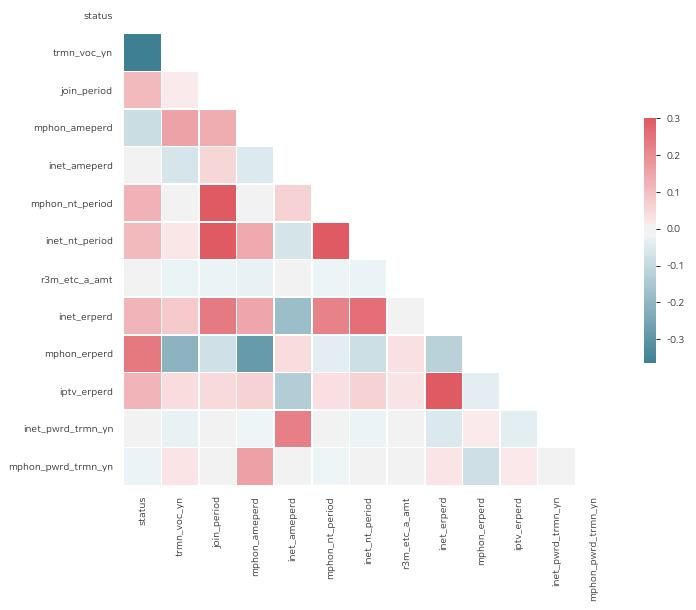

In [103]:
Image('image/co4.jpg')

In [95]:
def Rcdtoint(Rcd):
    if Rcd=='_':
        return int(38)
    elif Rcd=='000':
        return int(0)
    else:
        return int(Rcd[1:3]) #숫자만 남김

In [96]:
for column in nt_cols:
    new_column=column.replace('_aftmn_eperd_itg_cd','_ameperd')
    train_data[new_column]='' # 새로운 컬럼을 추가
    test_data[new_column]='' # 새로운 컬럼을 추가
    train_data[new_column]=train_data[column].map(lambda x:Rcdtoint(x))
    test_data[new_column]=test_data[column].map(lambda x:Rcdtoint(x))

In [97]:
train_data.iloc[:,-2:]

,mphon_ameperd,inet_ameperd
0,38,38
1,38,38
2,38,38
3,38,38
4,38,38
...,...,...
59995,38,38
59996,38,38
59997,38,38
59998,38,38


- XXX_nt_period(신규가입후 해지까지의 기간) 파생변수 추가 (신규가입 후 해지까지의 기간이 짧은 고객은 짧은 기간내 해지할 가능성이 높을 것으로 추정)

In [98]:
ameperd_cols=[]
for column in train_data.columns:
    if column[-8:]=='_ameperd':
        ameperd_cols.append(column)   
ameperd_cols

['mphon_ameperd', 'inet_ameperd']

    - XXX_term_date(해지일자) 파생변수 추가하고, 
    - XXX_nt_period(신규가입 후 해지까지의 기간) 계산하여 추가

In [104]:
for column in ameperd_cols:
    prod_name=column.replace('_ameperd','') #상품명을 따는 코드
    prod_term_date=prod_name+'_term_date' #해지일자 컬럼명을 만드는 코드
    prod_nt_period=prod_name+'_nt_period' #신규일자 - 해지일자 기간 컬럼명을 만드는 코드
    train_data[prod_term_date]=train_data[column].map(lambda x:datetime(2020,8,31,0,0) - relativedelta(months=x)) #숫자로 만든 해지후 경과기간을 데이터 추출일에서 빼서 해지일자를 파생변수로 만듬
    test_data[prod_term_date]=test_data[column].map(lambda x:datetime(2020,9,30,0,0) - relativedelta(months=x)) #test는 9월 말일자 데이터
    train_data[prod_nt_period]=((train_data[prod_term_date]- train_data['new_date']) / np.timedelta64(1, 'D')) #신규일자 - 해지일자 기간을 파생변수로 만듬
    test_data[prod_nt_period]=((test_data[prod_term_date] - test_data['new_date']) / np.timedelta64(1, 'D'))

In [105]:
pd.concat([train_data['status'],train_data.iloc[:,-4:]],axis=1)

,status,mphon_term_date,mphon_nt_period,inet_term_date,inet_nt_period
0,Y,2017-06-30,70.0,2017-06-30,70.0
1,N,2017-06-30,1305.0,2017-06-30,1305.0
2,N,2017-06-30,-31.0,2017-06-30,-31.0
3,Y,2017-06-30,2830.0,2017-06-30,2830.0
4,N,2017-06-30,587.0,2017-06-30,587.0
...,...,...,...,...,...
59995,N,2017-06-30,-574.0,2017-06-30,-574.0
59996,Y,2017-06-30,78.0,2017-06-30,78.0
59997,N,2017-06-30,243.0,2017-06-30,243.0
59998,N,2017-06-30,274.0,2017-06-30,274.0


해지하지 않은 경우에도 해지일자(term_date)가 2020/08/31이 되나, term_date는 삭제하고, nt_period를 구하기 위한 것이므로 상관없음 

### 1.2.3 XXX_r3m_amt (3개월 평균 청구요금) 관련 파생변수 추가

- 3개월 총청구요금에서 상품별 3개월 평균 청구요금(회선당) * 유효상품 갯수와 PPV 평균 사용금액을 뺀 요금을 파생변수로 추가 --> 소액결제 등이 대부분일 것으로 보이며, 경험상 소액결제 요금은 해지에 큰 영향이 있음

In [106]:
train_data['r3m_etc_amt']=train_data['r3m_avg_bill_amt']-train_data['r3m_mphon_avg_arpu_amt']*train_data['efct_mphon_sbsc_cascnt']-train_data['r3m_inet_avg_arpu_amt']*train_data['efct_inet_sbsc_cascnt']-train_data['r3m_ppv_avg_use_amt']
test_data['r3m_etc_amt']=test_data['r3m_avg_bill_amt']-test_data['r3m_mphon_avg_arpu_amt']*test_data['efct_mphon_sbsc_cascnt']-test_data['r3m_inet_avg_arpu_amt']*test_data['efct_inet_sbsc_cascnt']-test_data['r3m_ppv_avg_use_amt']


- 3개월 총청구요금에서 상품별 3개월 평균 청구요금과 PPV 평균 사용금액을 뺀 요금을 파생변수로 추가 

  상품별 3개월 평균 ARPU가 회선당인지 청구당인지 불명확하므로 파생변수를 하나더 추가함(청구당)

In [107]:
train_data['r3m_etc_a_amt']=train_data['r3m_avg_bill_amt']-train_data['r3m_mphon_avg_arpu_amt']-train_data['r3m_inet_avg_arpu_amt']-train_data['r3m_ppv_avg_use_amt']
test_data['r3m_etc_a_amt']=test_data['r3m_avg_bill_amt']-test_data['r3m_mphon_avg_arpu_amt']-test_data['r3m_inet_avg_arpu_amt']-test_data['r3m_ppv_avg_use_amt']


In [108]:
train_data.shape, test_data.shape

((60000, 76), (10000, 75))

### 1.2.4 XXX_r6m_amt (6개월 평균 청구요금) 관련 파생변수 추가

- 3개월 관련 파생변수와 동일함

In [109]:
train_data['r6m_etc_amt']=train_data['r3m_avg_bill_amt']-train_data['r6m_mphon_avg_arpu_amt']*train_data['efct_mphon_sbsc_cascnt']-train_data['r6m_inet_avg_arpu_amt']*train_data['efct_inet_sbsc_cascnt']-train_data['r3m_ppv_avg_use_amt']
test_data['r6m_etc_amt']=test_data['r3m_avg_bill_amt']-test_data['r6m_mphon_avg_arpu_amt']*test_data['efct_mphon_sbsc_cascnt']-test_data['r6m_inet_avg_arpu_amt']*test_data['efct_inet_sbsc_cascnt']-test_data['r3m_ppv_avg_use_amt']


In [110]:
train_data['r6m_etc_a_amt']=train_data['r3m_avg_bill_amt']-train_data['r6m_mphon_avg_arpu_amt']-train_data['r6m_inet_avg_arpu_amt']-train_data['r3m_ppv_avg_use_amt']
test_data['r6m_etc_a_amt']=test_data['r3m_avg_bill_amt']-test_data['r6m_mphon_avg_arpu_amt']-test_data['r6m_inet_avg_arpu_amt']-test_data['r3m_ppv_avg_use_amt']


In [111]:
train_data.head()

,status,new_date,mob_trmn_cnt,int_trmn_cnt,mob_cont_cnt,int_cont_cnt,cust_ctg_type_itg_cd,sex_type_itg_cd,vip_adm_tag_itg_cd,olcb_sbsc_yn,inet_sbsc_yn,soip_sbsc_yn,iptv_sbsc_yn,pstn_sbsc_yn,wibro_sbsc_yn,mphon_sbsc_yn,comb_prod_sbsc_yn,efct_mphon_sbsc_cascnt,efct_pstn_sbsc_cascnt,efct_soip_sbsc_cascnt,efct_inet_sbsc_cascnt,efct_iptv_sbsc_cascnt,efct_wibro_sbsc_cascnt,dt_stop_yn,inet_light_sbsc_yn,mphon_comb_yn,inet_comb_yn,iptv_comb_yn,mphon_aftmn_eperd_itg_cd,inet_aftmn_eperd_itg_cd,inet_trmn_why_itg_cd,mphon_trmn_why_itg_cd,npay_yn,rmonth_pstn_bill_amt,r3m_avg_bill_amt,r6m_inet_pssn_comb_yn,r3m_mphon_avg_arpu_amt,r3m_inet_avg_arpu_amt,r6m_mphon_avg_arpu_amt,r6m_inet_avg_arpu_amt,tngr_sbscr_exist_hshld_yn,smph_use_yn,kids_wless_adtn_svc_sbsc_yn,kids_wrlin_adtn_svc_sbsc_yn,iptv_infn_conts_use_yn,inet_engt_exp_rperd_itg_cd,mphon_engt_exp_rperd_itg_cd,iptv_engt_exp_rperd_itg_cd,kibot_sbsc_yn,pad_use_yn,r3m_ppv_avg_use_amt,r6m_iptv_first_ppv_use_yn,voc1_daycnt,voc2_daycnt,voc3_daycnt,voc4_daycnt,voc5_daycnt,voc6_daycnt,voc7_daycnt,voc8_daycnt,voc9_daycnt,voc10_daycnt,voc11_daycnt,voc12_daycnt,trmn_voc_yn,voc_sum_cnt,day_sum_cnt,join_period,mphon_ameperd,inet_ameperd,mphon_term_date,mphon_nt_period,inet_term_date,inet_nt_period,r3m_etc_amt,r3m_etc_a_amt,r6m_etc_amt,r6m_etc_a_amt
0,Y,2017-04-21,0,0,1,0,10001,F,_,Y,Y,N,Y,N,N,Y,Y,1.0,0.0,0.0,1.0,2.0,0.0,N,N,Y,Y,Y,_,_,_,_,Y,0.0,127237.000,Y,40393.333,21780.0,41749.517,21774.5,N,Y,N,N,N,R09,R12,R09,N,N,0.0,N,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,1,1228.0,38,38,2017-06-30,70.0,2017-06-30,70.0,65063.667,65063.667,63712.983,63712.983
1,N,2013-12-03,0,0,2,0,10001,M,BM,N,N,N,N,N,N,Y,N,1.0,0.0,0.0,0.0,0.0,0.0,N,N,N,N,N,_,_,_,_,N,0.0,36700.000,N,34460.500,0.0,35569.213,0.0,N,Y,N,N,N,_,R06,_,N,N,0.0,N,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,1,1,2463.0,38,38,2017-06-30,1305.0,2017-06-30,1305.0,2239.500,2239.500,1130.787,1130.787
2,N,2017-07-31,0,0,1,1,10001,M,_,N,Y,N,Y,Y,N,N,Y,0.0,1.0,0.0,1.0,2.0,0.0,N,N,Y,Y,Y,_,_,_,_,N,1100.0,30000.000,Y,0.000,14300.0,0.000,14300.0,N,N,N,N,N,000,_,000,N,N,0.0,N,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,1,1,1127.0,38,38,2017-06-30,-31.0,2017-06-30,-31.0,15700.000,15700.000,15700.000,15700.000
3,Y,2009-09-30,0,0,4,1,10001,F,BM,Y,Y,N,Y,N,N,Y,Y,1.0,0.0,0.0,1.0,1.0,0.0,N,N,Y,Y,Y,_,_,_,_,Y,0.0,72767.667,Y,34747.417,27500.0,34714.917,27500.0,N,Y,N,N,N,P36,R11,P36,N,N,0.0,N,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0,2,2,3988.0,38,38,2017-06-30,2830.0,2017-06-30,2830.0,10520.250,10520.250,10552.750,10552.750
4,N,2015-11-21,0,0,1,1,10001,F,BM,Y,Y,N,Y,Y,N,Y,Y,2.0,1.0,0.0,2.0,2.0,0.0,Y,N,Y,Y,Y,_,_,_,_,N,950.0,103365.333,Y,59856.279,27041.5,58386.112,25621.7,N,Y,N,N,N,R27,R22,R27,N,N,0.0,N,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,1,1,1745.0,38,38,2017-06-30,587.0,2017-06-30,587.0,-70430.225,16467.554,-64650.291,19357.521


### 1.2.5 XXX__engt_exp_rperd_itg_cd 관련 파생변수 추가

In [112]:
#약정만료기간통합코드 컬럼
erperd_cols=[]
for column in train_data.columns:
    if column[-22:]=='_engt_exp_rperd_itg_cd':
        erperd_cols.append(column)   
erperd_cols

['inet_engt_exp_rperd_itg_cd',
 'mphon_engt_exp_rperd_itg_cd',
 'iptv_engt_exp_rperd_itg_cd']

- 약정만료기간에 대해서는 '_'인 경우는 해당 상품에 가입하지 않은 것이므로 무약정
- 해지후 경과기간은 숫자가 클수록 영향이 작지만, 약정만료기간은 숫자가 클수록 영향이 큼(해지가능성이 높음)

- Aidu ez에서 확인한 Corrheatmap 상으로는 양의 상관관계를 가지나, BA판단에 따라 음의 상관관계를 가지는 것으로 판단하고 파생변수를 생성함

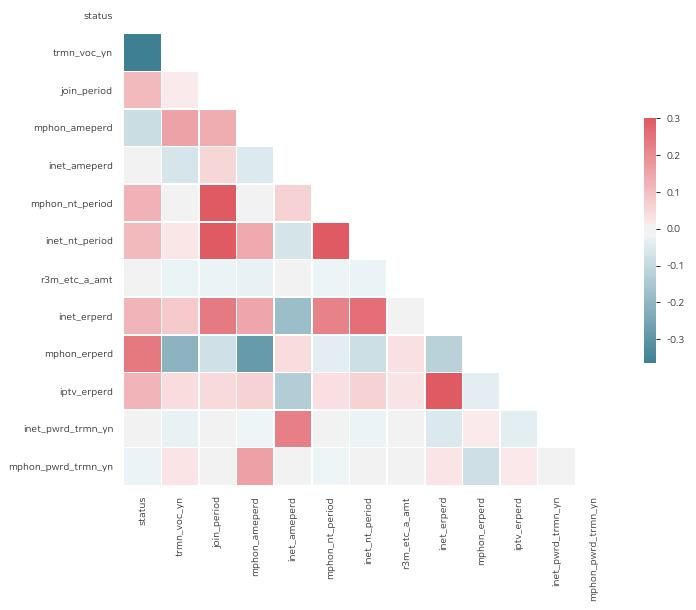

In [115]:
Image('image/co4.jpg')

- 약정 만료 잔여기간 코드를 int로 변경하여 추가

    - 코드값이 '-'인 경우는 해지하지 않은 경우이며, 0으로 처리함. 코드값 000과 구분 필요함
    - 코드값이 '000'인 경우는 해지후 경과기간이 당월 내인 경우이며, 1로 처리함
    - 코드값이 'RXX'인 경우에는 해지후 경과기간이 XX인 경우이며, 000을 1로 처리했으므로 +1을 해서 처리함
    - 코드값이 'P'인 경우는 무약정이나 마찬가지이므로 0으로 처리함(약정만료잔여기간통합코드인 경우)
    - 코드값이 '|'인 경우 무약정이므로 0으로 처리함(약정만료잔여기간통합코드인 경우)

In [116]:
def RPcdtoint(RPcd):
    if RPcd=='_': #가입하지 않았으니 무약정
        return int(0)
    elif RPcd=='000': #약정 만료 직전
        return int(1)
    elif RPcd[0]=='P': #약정 만료이면 무약정이나 마찬가지
        return int(0)
    elif RPcd=='|': #무약정
        return int(0)
    else:
        return int(RPcd[1:3])+1 #숫자만 남김

In [117]:
for column in erperd_cols:
    new_column=column.replace('_engt_exp_rperd_itg_cd','_erperd')
    train_data[new_column]='' # 새로운 컬럼을 추가
    test_data[new_column]='' # 새로운 컬럼을 추가
    train_data[new_column]=train_data[column].map(lambda x:RPcdtoint(x))
    test_data[new_column]=test_data[column].map(lambda x:RPcdtoint(x))

In [118]:
train_data.iloc[:,-3:].head()

,inet_erperd,mphon_erperd,iptv_erperd
0,10,13,10
1,0,7,0
2,1,0,1
3,0,12,0
4,28,23,28


### 1.2.7 직권해지여부 컬럼 추가(고영훈) 

In [119]:
#분석에 활용할 컬럼 선택
pwrd_trmn_cols=[]
for column in train_data.columns:
    if column[-16:]=='_trmn_why_itg_cd':
        pwrd_trmn_cols.append(column)   
#코드명에 '직권' 이 포함된 사유코드 18개
pwrd_trmn_cd = ['10111','10118','10241','10242','10246','10248','10576','11069','20242','20454','20488','27476','28603','35370','35894','35947','36043','36074']

In [120]:
pwrd_trmn_cols

['inet_trmn_why_itg_cd', 'mphon_trmn_why_itg_cd']

In [121]:
def Pwrdtrmn(why_cd):
        if why_cd in pwrd_trmn_cd:
            return 'Y'
        else:
            return 'N'   

In [122]:
for column in pwrd_trmn_cols:
    new_column=column.replace('_trmn_why_itg_cd','_pwrd_trmn_yn')
    train_data[new_column]='' # 새로운 컬럼을 추가
    test_data[new_column]='' # 새로운 컬럼을 추가
    train_data[new_column]=train_data[column].map(lambda x:Pwrdtrmn(x))
    test_data[new_column]=test_data[column].map(lambda x:Pwrdtrmn(x))

In [123]:
train_data.iloc[:,-2:].head()

,inet_pwrd_trmn_yn,mphon_pwrd_trmn_yn
0,N,N
1,N,N
2,N,N
3,N,N
4,N,N


## 1.3. 표준화/정규화

- 건수/금액/기간은 scale의 차이가 크므로 표준화/정규화가 필요함. 다만, 주력 모델인 XGB는 기본적으로 표준화/정규화 알고리즘이 들어가며, 표준화/정규화 결과 정확도가 떨어져서 트리모델에 대해서는 표준화/정규화 진행하지 않으나, 다른 알고리즘 테스트를 위해 코드는 남겨둠

- 대신 수치형 데이터 대부분은 로그를 씌워서 outlier의 영향을 줄임 (amt 컬럼은 0이 대부분이며, 데이터간 분산이 큼)

In [124]:
#표준화/정규화 대상 컬럼 추출 (건수/금액/기간은 편차가 크므로 정규화 필요함)
nomal_cols=[]
for column in train_data.columns:
    if ((column[-3:]=='cnt' or column[-3:]=='amt') or column[-6:]=='period') or column[-6:]=='erperd':
        nomal_cols.append(column)   
nomal_cols

['mob_trmn_cnt',
 'int_trmn_cnt',
 'mob_cont_cnt',
 'int_cont_cnt',
 'efct_mphon_sbsc_cascnt',
 'efct_pstn_sbsc_cascnt',
 'efct_soip_sbsc_cascnt',
 'efct_inet_sbsc_cascnt',
 'efct_iptv_sbsc_cascnt',
 'efct_wibro_sbsc_cascnt',
 'rmonth_pstn_bill_amt',
 'r3m_avg_bill_amt',
 'r3m_mphon_avg_arpu_amt',
 'r3m_inet_avg_arpu_amt',
 'r6m_mphon_avg_arpu_amt',
 'r6m_inet_avg_arpu_amt',
 'r3m_ppv_avg_use_amt',
 'voc1_daycnt',
 'voc2_daycnt',
 'voc3_daycnt',
 'voc4_daycnt',
 'voc5_daycnt',
 'voc6_daycnt',
 'voc7_daycnt',
 'voc8_daycnt',
 'voc9_daycnt',
 'voc10_daycnt',
 'voc11_daycnt',
 'voc12_daycnt',
 'voc_sum_cnt',
 'day_sum_cnt',
 'join_period',
 'mphon_nt_period',
 'inet_nt_period',
 'r3m_etc_amt',
 'r3m_etc_a_amt',
 'r6m_etc_amt',
 'r6m_etc_a_amt',
 'inet_erperd',
 'mphon_erperd',
 'iptv_erperd']

- 전처리 코딩 끝날때까지 표준화/정규화는 하지 않음(파생변수 만드는데 방해)

In [126]:
#이상치의 영향을 최소화 하도록 RobustScaler 사용
from sklearn.preprocessing import RobustScaler
robustScaler = RobustScaler()
train_data[nomal_cols] = robustScaler.fit_transform(train_data[nomal_cols])
test_data[nomal_cols]=robustScaler.transform(test_data[nomal_cols])

rmonth_pstn_bill_amt 이 컬럼이 표준화가 되지 않음.

In [127]:
train_data['rmonth_pstn_bill_amt'].describe()

count     60000.000000
mean       2726.708433
std       11060.568777
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max      867682.000000
Name: rmonth_pstn_bill_amt, dtype: float64

- 워낙 편차가 크고 데이터가 적어서 그냥 지워도 될것 같으나 일단 개별적으로 표준화 해줌

In [128]:
train_data['rmonth_pstn_bill_amt'] = (train_data['rmonth_pstn_bill_amt']  - train_data['rmonth_pstn_bill_amt'].mean()) / train_data['rmonth_pstn_bill_amt'].std()

test_data['rmonth_pstn_bill_amt'] = (test_data['rmonth_pstn_bill_amt']  - test_data['rmonth_pstn_bill_amt'].mean()) / test_data['rmonth_pstn_bill_amt'].std()

In [129]:
train_data.shape, test_data.shape

((60000, 83), (10000, 82))

## 1.4.최종적으로 불필요한 컬럼 삭제

### 1.4.1 날짜 컬럼 삭제

In [130]:
date_cols=[]
for column in train_data.columns:
    if column[-4:]=='date':
        date_cols.append(column)   
    

In [131]:
date_cols

['new_date', 'mphon_term_date', 'inet_term_date']

In [132]:
#date_cols 컬럼들을  삭제
train_data.drop(date_cols,axis=1,inplace=True)
test_data.drop(date_cols,axis=1,inplace=True)

### 1.4.2. train과 test가 단일 값을 가지는 컬럼 삭제

In [133]:
#각 컬럼을 groupby 했을 때, 행수가 1이면 단일값을 가진 것으로 봄
one_value_cols=[]
for column in train_data.columns:
    if len(train_data.groupby(column).count().index)==1 and len(test_data.groupby(column).count().index)==1:
        one_value_cols.append(column)
one_value_cols
        

['iptv_infn_conts_use_yn', 'kibot_sbsc_yn', 'r3m_ppv_avg_use_amt']

- 위 코드는 실행에 시간이 오래 걸리므로 한번 실행 후 아래와 같이 코드에 저장해둠

In [134]:
one_value_cols=['iptv_infn_conts_use_yn', 'kibot_sbsc_yn', 'r3m_ppv_avg_use_amt']

In [135]:
#단일값 컬럼 삭제
train_data.drop(one_value_cols,axis=1,inplace=True)
test_data.drop(one_value_cols,axis=1,inplace=True)

### 1.4.3 Wibro 제외 

- 2019년 12월 31일 LOB 디컴에 따라 유지가입자 데이터 등이 편향된 데이터로 존재, 해지여부 예측에 악영향을 미칠 것으로 우려됨(BA판단)

In [136]:
#wibro 컬럼 내역
wibro_cols = ['wibro_sbsc_yn','efct_wibro_sbsc_cascnt']
#wibro 컬럼 drop
train_data.drop(wibro_cols,axis=1,inplace=True)
test_data.drop(wibro_cols,axis=1,inplace=True)

In [137]:
train_data.head()

,status,mob_trmn_cnt,int_trmn_cnt,mob_cont_cnt,int_cont_cnt,cust_ctg_type_itg_cd,sex_type_itg_cd,vip_adm_tag_itg_cd,olcb_sbsc_yn,inet_sbsc_yn,soip_sbsc_yn,iptv_sbsc_yn,pstn_sbsc_yn,mphon_sbsc_yn,comb_prod_sbsc_yn,efct_mphon_sbsc_cascnt,efct_pstn_sbsc_cascnt,efct_soip_sbsc_cascnt,efct_inet_sbsc_cascnt,efct_iptv_sbsc_cascnt,dt_stop_yn,inet_light_sbsc_yn,mphon_comb_yn,inet_comb_yn,iptv_comb_yn,mphon_aftmn_eperd_itg_cd,inet_aftmn_eperd_itg_cd,inet_trmn_why_itg_cd,mphon_trmn_why_itg_cd,npay_yn,rmonth_pstn_bill_amt,r3m_avg_bill_amt,r6m_inet_pssn_comb_yn,r3m_mphon_avg_arpu_amt,r3m_inet_avg_arpu_amt,r6m_mphon_avg_arpu_amt,r6m_inet_avg_arpu_amt,tngr_sbscr_exist_hshld_yn,smph_use_yn,kids_wless_adtn_svc_sbsc_yn,kids_wrlin_adtn_svc_sbsc_yn,inet_engt_exp_rperd_itg_cd,mphon_engt_exp_rperd_itg_cd,iptv_engt_exp_rperd_itg_cd,pad_use_yn,r6m_iptv_first_ppv_use_yn,voc1_daycnt,voc2_daycnt,voc3_daycnt,voc4_daycnt,voc5_daycnt,voc6_daycnt,voc7_daycnt,voc8_daycnt,voc9_daycnt,voc10_daycnt,voc11_daycnt,voc12_daycnt,trmn_voc_yn,voc_sum_cnt,day_sum_cnt,join_period,mphon_ameperd,inet_ameperd,mphon_nt_period,inet_nt_period,r3m_etc_amt,r3m_etc_a_amt,r6m_etc_amt,r6m_etc_a_amt,inet_erperd,mphon_erperd,iptv_erperd,inet_pwrd_trmn_yn,mphon_pwrd_trmn_yn
0,Y,0.0,0.0,0.0,-1.0,10001,F,_,Y,Y,N,Y,N,Y,Y,0.0,0.0,0.0,0.0,2.0,N,N,Y,Y,Y,_,_,_,_,Y,-0.246525,0.804609,Y,0.255099,0.227472,0.289053,0.222040,N,Y,N,N,R09,R12,R09,N,N,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,-0.073129,38,38,-0.109505,-0.094527,1.597587,0.995162,1.549704,0.990208,1.0,0.2500,1.666667,N,N
1,N,0.0,0.0,1.0,-1.0,10001,M,BM,N,N,N,N,N,Y,N,0.0,0.0,0.0,-1.0,0.0,N,N,N,N,N,_,_,_,_,N,-0.246525,-0.394263,N,0.093197,-0.681581,0.117177,-0.666957,N,Y,N,N,_,R06,_,N,N,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,0.0,0.0,0.626984,38,38,0.576987,0.588170,-0.229156,-0.344440,-0.251455,-0.366517,0.0,-0.1250,0.000000,N,N
2,N,0.0,0.0,0.0,0.0,10001,M,_,N,Y,N,Y,Y,N,Y,-1.0,1.0,0.0,0.0,2.0,N,N,Y,Y,Y,_,_,_,_,N,-0.147073,-0.482983,Y,-0.847201,-0.084728,-0.872010,-0.083125,N,N,N,N,000,_,000,N,N,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0.0,0.0,-0.130385,38,38,-0.165648,-0.150359,0.162236,-0.057421,0.167857,-0.050670,0.1,-0.5625,0.166667,N,N
3,Y,0.0,0.0,3.0,0.0,10001,F,BM,Y,Y,N,Y,N,Y,Y,0.0,0.0,0.0,0.0,1.0,N,N,Y,Y,Y,_,_,_,_,Y,-0.246525,0.083337,Y,0.101027,0.466213,0.093419,0.455798,N,Y,N,N,P36,R11,P36,N,N,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0,1.0,1.0,1.491497,38,38,1.424680,1.431177,0.011624,-0.167869,0.019716,-0.162258,0.0,0.1875,0.000000,N,N
4,N,0.0,0.0,0.0,0.0,10001,F,BM,Y,Y,N,Y,Y,Y,Y,1.0,1.0,0.0,1.0,2.0,Y,N,Y,Y,Y,_,_,_,_,N,-0.160634,0.488505,Y,0.786227,0.447076,0.751720,0.379111,N,Y,N,N,R27,R22,R27,N,N,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,0.0,0.0,0.219955,38,38,0.177877,0.191266,-2.342179,-0.041054,-2.144680,0.028622,2.8,0.8750,4.666667,N,N


In [138]:
train_data.shape, test_data.shape

((60000, 75), (10000, 74))

# **2. Encoding**

## 2.1 Lable Encoding

문자 컬럼들을 숫자로 변경 (ex. Y/N인 경우와 코드값들)
트리기반 모델에서는 원핫을 안해도 무방하나, 선형회귀같은 모델에서는 원핫을 해야함
Y/N은 레이블인코딩만 해도 되고, 코드 값들은 원핫까지 함

#### 2.1.1 Label Encoding 대상 추출 및 변환

라벨인코딩 대상으로 yn이나 cd로 끝나는 컬럼명을 가지고 있음

In [139]:
#라벨 인코딩 대상 컬럼 찾기
le_columns=[]
for i in train_data.columns:
    if i[-2:]=='cd' or i[-2:]=='yn':
        le_columns.append(i)

In [140]:
le_columns

['cust_ctg_type_itg_cd',
 'sex_type_itg_cd',
 'vip_adm_tag_itg_cd',
 'olcb_sbsc_yn',
 'inet_sbsc_yn',
 'soip_sbsc_yn',
 'iptv_sbsc_yn',
 'pstn_sbsc_yn',
 'mphon_sbsc_yn',
 'comb_prod_sbsc_yn',
 'dt_stop_yn',
 'inet_light_sbsc_yn',
 'mphon_comb_yn',
 'inet_comb_yn',
 'iptv_comb_yn',
 'mphon_aftmn_eperd_itg_cd',
 'inet_aftmn_eperd_itg_cd',
 'inet_trmn_why_itg_cd',
 'mphon_trmn_why_itg_cd',
 'npay_yn',
 'r6m_inet_pssn_comb_yn',
 'tngr_sbscr_exist_hshld_yn',
 'smph_use_yn',
 'kids_wless_adtn_svc_sbsc_yn',
 'kids_wrlin_adtn_svc_sbsc_yn',
 'inet_engt_exp_rperd_itg_cd',
 'mphon_engt_exp_rperd_itg_cd',
 'iptv_engt_exp_rperd_itg_cd',
 'pad_use_yn',
 'r6m_iptv_first_ppv_use_yn',
 'trmn_voc_yn',
 'inet_pwrd_trmn_yn',
 'mphon_pwrd_trmn_yn']

In [141]:
from sklearn.preprocessing import LabelEncoder

# LabelEncoder를 객체로 생성한 후 , fit( ) 과 transform( ) 으로 label 인코딩 수행. 
le = LabelEncoder()


for column in le_columns:
    le.fit(train_data[column])
    train_data[column]=le.transform(train_data[column])
    #train_data에 없는 label이 test_data에 있을 수 있으므로 아래 코드가 필요하며, test_data는 fit 없이 transform만 해야함
    for label in np.unique(test_data[column]):
        if label not in le.classes_: # unseen label 데이터인 경우( )
            le.classes_ = np.append(le.classes_, label) # 미처리 시 ValueError발생
    test_data[column]=le.transform(test_data[column])        

le.fit(train_data['status'])
train_data['status']=le.transform(train_data['status'])

In [915]:
le.classes_

array(['N', 'Y'], dtype=object)

### 2.2 인코딩 완료된 데이터 저장

- 저장파일명 규칙 
    - PC : 전처리 완료
    - PCS : 전처리 + 표준화 완료
    - PCSD : 전처리 +표준화 + 피처드롭
    - PCSDE : 전처리 + 표준화 + 피처드롭 + 라벨인코딩
    - PCSDEO : 전처리 + 표준화 + 피처드롭 + 라벨인코딩 + 원핫인코딩
    - PCSDEO_T : 전처리 + 표준화 + 피처드롭 + 라벨인코딩 + 원핫인코딩 + 테스트 데이터 추가
    - PCSDEO_TD : 전처리 + 표준화 + 피처드롭 + 라벨인코딩 + 원핫인코딩 + 테스트 데이터 추가 + 데이터삭제

In [142]:
#순수 train일때 Label Encoding 완료 데이터 저장
train_data.to_csv(sacp_framework.config.data_dir + '/train_data_PCE.csv',header=True, index=False, encoding='utf-8')

test_data.to_csv(sacp_framework.config.data_dir + '/test_data_PCE.csv',header=True, index=False, encoding='utf-8')

In [ ]:
#순수 train일때 Onehot Encoding 완료 데이터 저장
train_data.to_csv(sacp_framework.config.data_dir + '/train_data_PCEO.csv',header=True, index=False, encoding='utf-8')

test_data.to_csv(sacp_framework.config.data_dir + '/test_data_PCEO.csv',header=True, index=False, encoding='utf-8')

In [247]:
#순수 train일때 feature 정리한 데이터 로드
train_data= pd.read_csv(sacp_framework.config.data_dir + '/train_data_D44.csv')

test_data = pd.read_csv(sacp_framework.config.data_dir + '/test_data_D44.csv')

# 3.모델링

## 3.0. 데이터 분할

### 3.0.1 일단 당장의 모델은 train 데이터를 분할하여 검증하면서 진행한다

In [143]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(train_data.drop('status',1),train_data['status'],random_state=21)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((45000, 74), (15000, 74), (45000,), (15000,))

### 3.0.2 실제 예측을 위한 데이터 or k겹교차일때 데이터

In [144]:
X_train = train_data.drop('status',axis=1)

Y_train = train_data['status']

X_test = test_data

X_train.shape, X_test.shape, Y_train.shape #Y_test는 없음

((60000, 74), (10000, 74), (60000,))

- 데이터 셋에 변경이 될 때마다 사용하므로 함수로 만든다

In [145]:
def datasplit():
    from sklearn.model_selection import train_test_split

    x_train, x_test, y_train, y_test = train_test_split(train_data.drop('status',1),train_data['status'],random_state=21)
    print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)
    X_train = train_data.drop('status',axis=1)

    Y_train = train_data['status']

    X_test = test_data
    print(X_train.shape, X_test.shape, Y_train.shape) #Y_test는 없음

In [146]:
datasplit()

(45000, 74) (15000, 74) (45000,) (15000,)
(60000, 74) (10000, 74) (60000,)


## 3.1. 모델별 성능 그래프

### 3.1.1. 모델별 성능을 저장하기 위한 함수 선언

In [147]:
import matplotlib.pyplot as plt
import seaborn as sns

my_predictions = {}

colors = ['r', 'c', 'm', 'y', 'k', 'khaki', 'teal', 'orchid', 'sandybrown',
          'greenyellow', 'dodgerblue', 'deepskyblue', 'rosybrown', 'firebrick',
          'deeppink', 'crimson', 'salmon', 'darkred', 'olivedrab', 'olive', 
          'forestgreen', 'royalblue', 'indigo', 'navy', 'mediumpurple', 'chocolate',
          'gold', 'darkorange', 'seagreen', 'turquoise', 'steelblue', 'slategray', 
          'peru', 'midnightblue', 'slateblue', 'dimgray', 'cadetblue', 'tomato'
         ]


#acc를 구해서 시각화해줌
def acc_eval(name_, pred, actual):
    global predictions
    global colors

    acc = (pred==actual).mean()
    my_predictions[name_] = acc


    y_value = sorted(my_predictions.items(), key=lambda x: x[1], reverse=False)  # 정확도 내림차순으로 sort
    
    df = pd.DataFrame(y_value, columns=['model', 'acc'])
    print(df)
    min_ = df['acc'].min() -1
    max_ = 1.2
    
    length = len(df)
    
    plt.figure(figsize=(10, length))
    ax = plt.subplot()
    ax.set_yticks(np.arange(len(df)))
    ax.set_yticklabels(df['model'], fontsize=15)
    bars = ax.barh(np.arange(len(df)), df['acc'])
    
    for i, v in enumerate(df['acc']):
        idx = np.random.choice(len(colors))
        bars[i].set_color(colors[idx])
        ax.text(v+0.1, i, str(round(v, 3)), color='k', fontsize=15, fontweight='bold')
        
    plt.title('Accuracy', fontsize=18)
    plt.xlim(min_,max_)
    
    plt.show()
    
#acc를 구해서 시각화해줌(cross_val_score 사용하는 경우)
def acc_eval_add(name_, acc):
    global predictions
    global colors

    my_predictions[name_] = acc


    y_value = sorted(my_predictions.items(), key=lambda x: x[1], reverse=False)  # 정확도 내림차순으로 sort
    
    df = pd.DataFrame(y_value, columns=['model', 'acc'])
    print(df)
    min_ = df['acc'].min() -1
    max_ = 1.2
    
    length = len(df)
    
    plt.figure(figsize=(10, length))
    ax = plt.subplot()
    ax.set_yticks(np.arange(len(df)))
    ax.set_yticklabels(df['model'], fontsize=15)
    bars = ax.barh(np.arange(len(df)), df['acc'])
    
    for i, v in enumerate(df['acc']):
        idx = np.random.choice(len(colors))
        bars[i].set_color(colors[idx])
        ax.text(v+0.1, i, str(round(v, 3)), color='k', fontsize=15, fontweight='bold')
        
    plt.title('Accuracy', fontsize=18)
    plt.xlim(min_,max_)
    
    plt.show()
    
#실수로 잘못 넣은 경우 해당 모델을 삭제
def remove_model(name_):
    global my_predictions
    try:
        del my_predictions[name_]
    except KeyError:
        return False
    return True

In [148]:
# #IDE 종료등으로 모델링 결과를 잃어버리지 않도록 저장한 경우 로딩하는 코드
# #csv 파일을 dict로 로딩
# with open(sacp_framework.config.data_dir + '/my_predictions.csv','r') as f:
#     r = csv.DictReader(f)
#     for row in r:
#         my_predictions.update(row)

# #그냥 읽으면 정확도가 문자로 읽혀짐
# for value in my_predictions:
#     my_predictions[value] = float(my_predictions[value])

In [149]:
my_predictions

{}

## 3.2 기본 모델 생성

In [150]:
from sklearn.model_selection import cross_val_score

### 3.2.1. 랜덤포레스트

In [151]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_jobs=-1)

start=time.time()

score=cross_val_score(model,X_train,Y_train).mean()
(time.time()-start)/60

0.3820108453432719

      model       acc
0  RF_Basic  0.771367


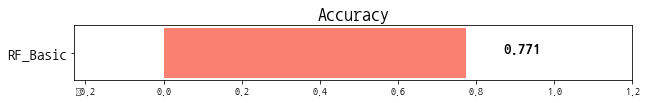

In [152]:
acc_eval_add('RF_Basic',score) #기본

### 3.2.2. XGBoost 

In [154]:
#기본 모델은 시간이 오래 걸려서 CV를 하지 않음.
from xgboost import XGBClassifier

xgb_model = XGBClassifier(n_jobs=-1)

start=time.time()

eval_set = [(x_test, y_test)]

#logloss가 10회 계선되지 않으면 중단하도록 early stopping 설정 n_estimators=100에서는 얼리스탑하지 않음
xgb_model.fit(x_train, y_train,early_stopping_rounds=10, eval_metric="logloss", eval_set=eval_set, verbose=True)

(time.time()-start)/60

[0]	validation_0-logloss:0.61315
Will train until validation_0-logloss hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.56993
[2]	validation_0-logloss:0.54347
[3]	validation_0-logloss:0.52594
[4]	validation_0-logloss:0.51407
[5]	validation_0-logloss:0.50488
[6]	validation_0-logloss:0.49889
[7]	validation_0-logloss:0.49515
[8]	validation_0-logloss:0.49281
[9]	validation_0-logloss:0.48987
[10]	validation_0-logloss:0.48806
[11]	validation_0-logloss:0.48620
[12]	validation_0-logloss:0.48432
[13]	validation_0-logloss:0.48359
[14]	validation_0-logloss:0.48279
[15]	validation_0-logloss:0.48172
[16]	validation_0-logloss:0.48092
[17]	validation_0-logloss:0.48059
[18]	validation_0-logloss:0.47964
[19]	validation_0-logloss:0.47838
[20]	validation_0-logloss:0.47814
[21]	validation_0-logloss:0.47727
[22]	validation_0-logloss:0.47663
[23]	validation_0-logloss:0.47622
[24]	validation_0-logloss:0.47579
[25]	validation_0-logloss:0.47552
[26]	validation_0-logloss:0.47507
[27]	validation_0-loglos

0.16394503116607667

In [155]:
pred=xgb_model.predict(x_test)

       model       acc
0   RF_Basic  0.771367
1  XGB_BASIC  0.775400


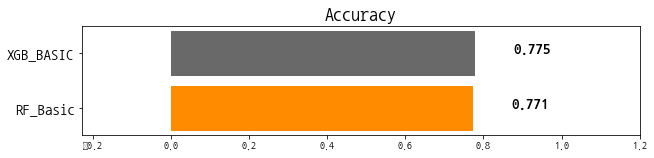

In [156]:
acc_eval('XGB_BASIC',pred,y_test) #기본

### 3.2.3 CATBoost

In [159]:
from catboost import CatBoostClassifier

cat_model = CatBoostClassifier()

start=time.time()

cat_model.fit(x_train, y_train)

(time.time()-start)/60

pred = cat_model.predict(x_test)

Learning rate set to 0.052343
0:	learn: 0.6747717	total: 498ms	remaining: 8m 17s
1:	learn: 0.6589573	total: 904ms	remaining: 7m 31s
2:	learn: 0.6449806	total: 1.59s	remaining: 8m 48s
3:	learn: 0.6330767	total: 1.9s	remaining: 7m 52s
4:	learn: 0.6214593	total: 2.69s	remaining: 8m 55s
5:	learn: 0.6120146	total: 3.4s	remaining: 9m 23s
6:	learn: 0.6027041	total: 4s	remaining: 9m 26s
7:	learn: 0.5945684	total: 4.49s	remaining: 9m 17s
8:	learn: 0.5876685	total: 4.9s	remaining: 8m 59s
9:	learn: 0.5810256	total: 5.39s	remaining: 8m 53s
10:	learn: 0.5754221	total: 5.9s	remaining: 8m 50s
11:	learn: 0.5700209	total: 6.15s	remaining: 8m 26s
12:	learn: 0.5650058	total: 6.52s	remaining: 8m 15s
13:	learn: 0.5607698	total: 7.01s	remaining: 8m 13s
14:	learn: 0.5564342	total: 7.78s	remaining: 8m 30s
15:	learn: 0.5530028	total: 8.39s	remaining: 8m 36s
16:	learn: 0.5498778	total: 9.01s	remaining: 8m 40s
17:	learn: 0.5471704	total: 9.42s	remaining: 8m 33s
18:	learn: 0.5443387	total: 10s	remaining: 8m 36s
1

       model       acc
0   RF_Basic  0.771367
1  XGB_BASIC  0.775400
2  CAT_Basic  0.779133


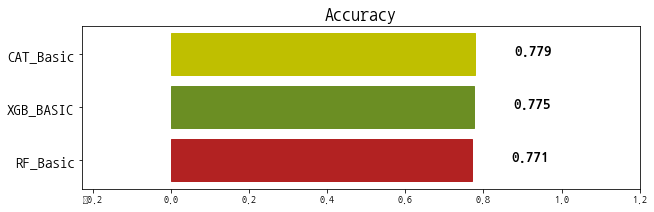

In [160]:
acc_eval('CAT_Basic',pred,y_test) #기본

In [161]:
(time.time()-start)/60

12.637021140257518

### 3.2.4 LightGBM

In [162]:
from lightgbm import LGBMClassifier

lgbm_model = LGBMClassifier()

start=time.time()


eval_set = [(x_test, y_test)]

#logloss가 10회 계선되지 않으면 중단하도록 early stopping 설정 n_estimators=100에서는 얼리스탑하지 않음
lgbm_model.fit(x_train, y_train,early_stopping_rounds=10, eval_metric="logloss", eval_set=eval_set, verbose=True)

(time.time()-start)/60

[1]	valid_0's binary_logloss: 0.653816
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.631096
[3]	valid_0's binary_logloss: 0.612272
[4]	valid_0's binary_logloss: 0.596394
[5]	valid_0's binary_logloss: 0.583336
[6]	valid_0's binary_logloss: 0.572028
[7]	valid_0's binary_logloss: 0.562248
[8]	valid_0's binary_logloss: 0.553651
[9]	valid_0's binary_logloss: 0.546386
[10]	valid_0's binary_logloss: 0.539961
[11]	valid_0's binary_logloss: 0.534496
[12]	valid_0's binary_logloss: 0.529675
[13]	valid_0's binary_logloss: 0.525449
[14]	valid_0's binary_logloss: 0.521446
[15]	valid_0's binary_logloss: 0.518048
[16]	valid_0's binary_logloss: 0.514594
[17]	valid_0's binary_logloss: 0.511254
[18]	valid_0's binary_logloss: 0.508671
[19]	valid_0's binary_logloss: 0.506243
[20]	valid_0's binary_logloss: 0.504311
[21]	valid_0's binary_logloss: 0.501989
[22]	valid_0's binary_logloss: 0.500202
[23]	valid_0's binary_logloss: 0.498108
[24]	valid_0's binary_loglos

0.038334592183430986

In [163]:
pred = lgbm_model.predict(x_test)

        model       acc
0    RF_Basic  0.771367
1   XGB_BASIC  0.775400
2  LGBM_Basic  0.775867
3   CAT_Basic  0.779133


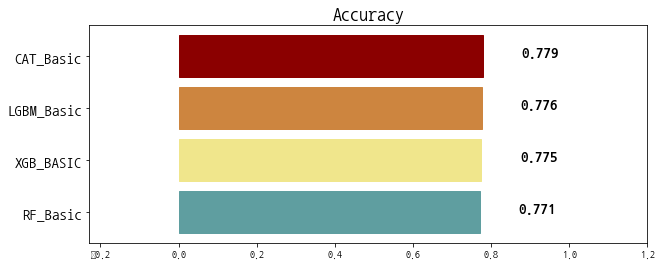

In [164]:
acc_eval('LGBM_Basic',pred,y_test) #기본

## 3.4. 모델링 결과 저장

In [165]:
import csv
with open(sacp_framework.config.data_dir + '/my_predictions.csv','w') as f:
    w = csv.writer(f)
    w.writerow(my_predictions.keys())
    w.writerow(my_predictions.values())

In [166]:
my_predictions

{'RF_Basic': 0.7713666666666666,
 'XGB_BASIC': 0.7754,
 'CAT_Basic': 0.7791333333333333,
 'LGBM_Basic': 0.7758666666666667}

# **4. 모델 튜닝 ( Bayesian Optimization )**

## 4.1. XGBoost 튜닝

Bayesian Optimaization 튜닝은 iteration이 클 수록 시간이 오래 걸리기 때문에 IDE에서 돌리기 어려우므로 Aidu의 모델학습으로 진행함

==============================================여기부터========================================================

In [ ]:
subprocess.call([sys.executable,"-m","pip","install","bayesian-optimization"]) 

In [ ]:
from sklearn import metrics   #Additional scklearn functions
from sklearn.model_selection import cross_val_score
from bayes_opt import BayesianOptimization

### 4.1.1. 최적화 함수 정의

In [ ]:
import xgboost as xgb
def XGB_cv(max_depth,learning_rate, n_estimators, gamma, min_child_weight,max_delta_step,subsample,colsample_bytree,silent=True, nthread=-1):
    model = xgb.XGBClassifier(max_depth=int(max_depth),
                              learning_rate=learning_rate,
                              n_estimators=int(n_estimators),
                              nthread=nthread,
                              gamma=gamma,
                              min_child_weight=min_child_weight,
                              max_delta_step=max_delta_step,
                              subsample=subsample,
                              colsample_bytree=colsample_bytree)
    
#     # 모델 훈련
#     model.fit(x_train, y_train)

#     # 예측값 출력
#     y_pred= model.predict(x_test)
    
    # 각종 metric 계산
    acc = cross_val_score(model, X_train, Y_train, scoring='accuracy', cv=5).mean()
    
    return acc

In [ ]:
# 주어진 범위 사이에서 적절한 값을 찾는다.
pbounds = {'max_depth': (5, 10),
          'learning_rate': (0.01, 0.3),
          'n_estimators': (50, 300),
          'gamma': (1., 0.01),
          'min_child_weight': (2, 10),
          'max_delta_step': (0, 0.1),
          'subsample': (0.7, 0.9),
          'colsample_bytree' :(0.5, 0.99)          
          }

In [ ]:
# Bayesian optimization 객체 생성
# f : 탐색 대상 함수, pbounds : hyperparameter 집합
# verbose = 2 항상 출력, verbose = 1 최댓값일 때 출력, verbose = 0 출력 안함
# random_state : Bayesian Optimization 상의 랜덤성이 존재하는 부분을 통제
xgboostBO = BayesianOptimization(f = XGB_cv,pbounds = pbounds, verbose = 2, random_state = 1 )

In [ ]:
start=time.time()

In [ ]:
# 메소드를 이용해 최대화 과정 수행
# init_points :  초기 Random Search 갯수
# n_iter : 반복 횟수 (몇개의 입력값-함숫값 점들을 확인할지! 많을 수록 정확한 값을 얻을 수 있다.)
# acq : Acquisition Function들 중 Expected Improvement(EI) 를 사용
# xi : exploration 강도 (기본값은 0.0)
xgboostBO.maximize(init_points=4, n_iter = 40, acq='ei', xi=0.01)


In [ ]:
print('BO Time(min): {:.2f}'.format((time.time()-start)/60))

In [ ]:
# ‘iter’는 반복 회차, ‘target’은 목적 함수의 값, 나머지는 입력값을 나타냅니다. 
# 현재 회차 이전까지 조사된 함숫값들과 비교하여, 현재 회차에 최댓값이 얻어진 경우, 
# bayesian-optimization 라이브러리는 이를 자동으로 다른 색 글자로 표시하는 것을 확인할 수 있습니다

# 찾은 파라미터 값 확인
print(xgboostBO.max)

In [ ]:
fit_xgb = xgb.XGBClassifier(max_depth= int( xgboostBO.max['params']['max_depth'] ),
                             learning_rate=xgboostBO.max['params']['learning_rate'],
                             n_estimators=int(xgboostBO.max['params']['n_estimators']),
                             gamma= xgboostBO.max['params']['gamma'],
                             min_child_weight=xgboostBO.max['params']['min_child_weight'],
                             max_delta_step=xgboostBO.max['params']['max_delta_step'],
                             subsample=xgboostBO.max['params']['subsample'],
                             colsample_bytree=xgboostBO.max['params']['colsample_bytree'],
                             n_jobs=-1)

In [ ]:
fit_xgb.fit(x_train,y_train)

In [ ]:
pred_XGB = fit_xgb.predict(x_test)



In [ ]:
print('BO_acc: ',(pred_XGB==y_test).mean())

===============================================여기까지=============================================================================

### 4.1.2. Bayesian Optimization 으로 찾은 파라미터를 적용하여 결과를 확인한다.

In [167]:
from xgboost import XGBClassifier

model = XGBClassifier(
        colsample_bytree= 0.5532036630135703, 
        gamma=1.0, 
        learning_rate= 0.1555825731884874, 
        max_delta_step= 0.09038638082244055, 
        max_depth= 9, 
        min_child_weight= 6.462834212552353, 
        n_estimators= 269, 
        subsample= 0.8740670584510566,
                      n_jobs=-1)

In [168]:
start = time.time()

score_list=cross_val_score(model,X_train,Y_train)

(time.time()-start)/60

3.9315905968348184

        model       acc
0    RF_Basic  0.771367
1   XGB_BASIC  0.775400
2      XGB_BO  0.775417
3  LGBM_Basic  0.775867
4   CAT_Basic  0.779133


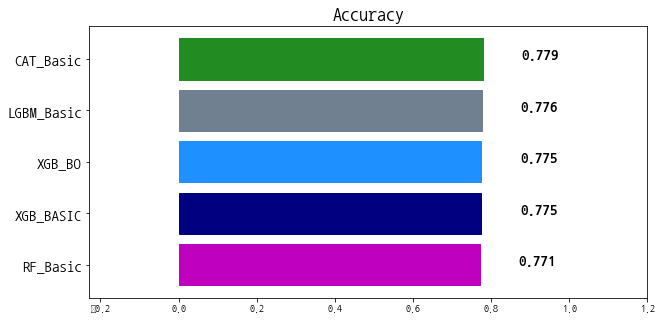

In [169]:
acc_eval_add('XGB_BO',score_list.mean()) #BO적용 후 

# **5. 변수중요도 확인을 통해 변수 선택**

## 5.1 변수 중요도 확인 및 삭제

- 현재 성능이 가장 좋은 모델의 변수중요도를 확인한다

- RFE/ SelectModelFeature 등 활용하여 다양한 방법으로 변수중요도를 확인하고 테스트 해보았으나,(3.AIZOA_자가학습서_변수선택)
  
  XGBoost 모델의 Feature Importance를 통해 적정한 임계값 범위의 변수를 선택하는 것이 가장 성능이 높게 나옴

In [170]:
from xgboost import XGBClassifier

model = XGBClassifier(
        colsample_bytree= 0.5532036630135703, 
        gamma=1.0, 
        learning_rate= 0.1555825731884874, 
        max_delta_step= 0.09038638082244055, 
        max_depth= 9, 
        min_child_weight= 6.462834212552353, 
        n_estimators= 269, 
        subsample= 0.8740670584510566,
                      n_jobs=-1)

model.fit(x_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5532036630135703,
              gamma=1.0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.1555825731884874,
              max_delta_step=0.09038638082244055, max_depth=9,
              min_child_weight=6.462834212552353, missing=nan,
              monotone_constraints='()', n_estimators=269, n_jobs=-1,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=0.8740670584510566,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [171]:
pred=model.predict(x_test)

- Tree 계열 모델은 feature_importance를 기본적으로 제공함

In [172]:
feature_importance = pd.concat([pd.Series(train_data.columns[1:]),pd.Series(xgb_model.feature_importances_)],axis=1,ignore_index=True)

In [173]:
#내림차순으로 변수중요도 정렬함
feature_imp=feature_importance.sort_values(by=1 ,ascending=False)

In [174]:
pd.set_option('display.max_row',100)

In [175]:
feature_imp

,0,1
13,comb_prod_sbsc_yn,0.254706
53,voc9_daycnt,0.229986
22,inet_comb_yn,0.113345
21,mphon_comb_yn,0.045379
70,mphon_erperd,0.033032
19,dt_stop_yn,0.021383
69,inet_erperd,0.021090
14,efct_mphon_sbsc_cascnt,0.012024
60,join_period,0.011528
0,mob_trmn_cnt,0.011265


In [176]:
len(feature_imp)

74

- 중요변수가 차지하는 영향도에 대해 임계치를 정하고 해당하는 컬럼을 추출한다

  0.5~0.9 사이에서 변수 추출 및 테스트 한 결과 0.7에서 가장 성능이 좋음

In [177]:
cnt=0
sum_rate=0.0
for i in feature_imp.index:
    sum_rate=sum_rate+feature_imp.iloc[i,1]
    cnt=cnt+1
    if sum_rate > 0.7:
        print("변수 갯수: ",cnt)
        break
        
    

변수 갯수:  58


- 변수중요도를 시각화 해서 본다

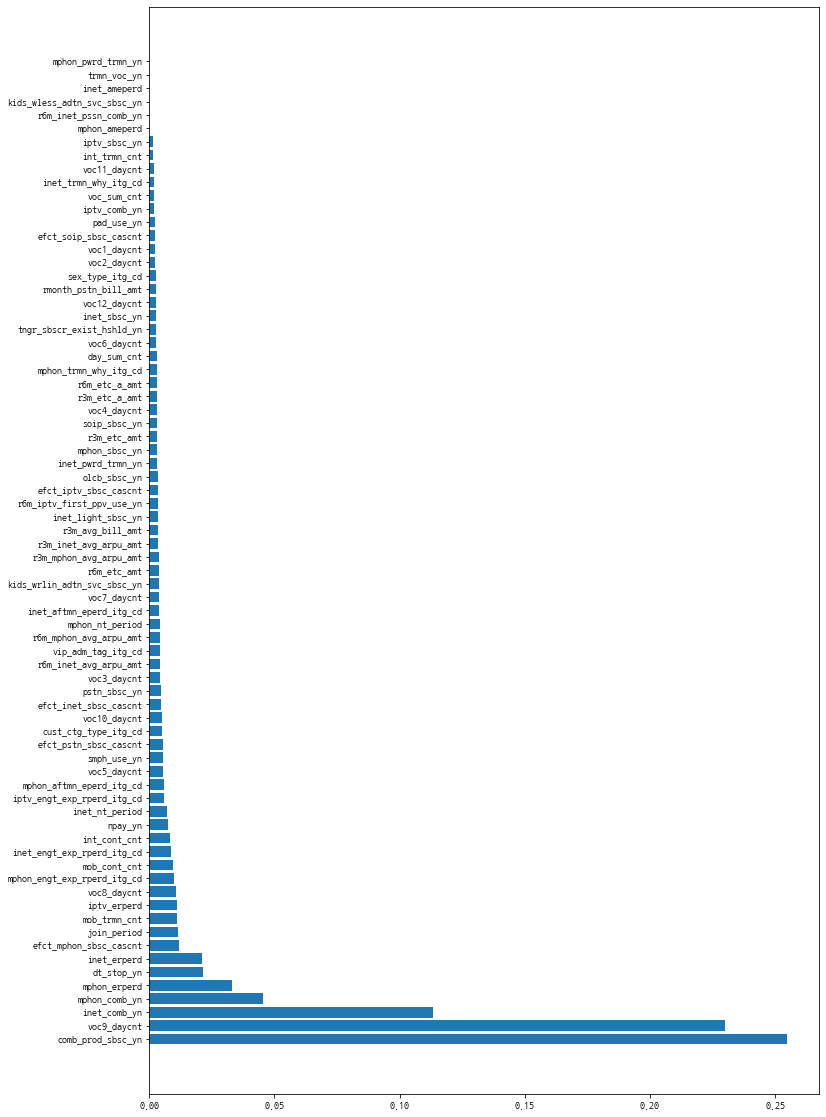

In [178]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 20
from matplotlib import pyplot
pyplot.barh(feature_imp[0], feature_imp[1])
pyplot.show()

- feature importance가 낮은 feature는 데이터에서 삭제하고 저장한다

In [939]:
drop_cols=feature_imp.iloc[44:,0]

In [940]:
train_data.drop(drop_cols,axis=1,inplace=True)

test_data.drop(drop_cols,axis=1,inplace=True)

In [949]:
train_data.shape, test_data.shape

((62863, 45), (10000, 44))

In [179]:
#순수 train일때 변수 선택 후 저장
train_data.to_csv(sacp_framework.config.data_dir + '/train_data_D44.csv',header=True, index=False, encoding='utf-8')

test_data.to_csv(sacp_framework.config.data_dir + '/test_data_D44.csv',header=True, index=False, encoding='utf-8')

In [942]:
# #Under/Oversampling 후 데이터에 대해 변수 선택 후 저장 - 최종파일이니 소중히 다루세요 (마지막에 주석 풀고 사용)
# train_data.to_csv(sacp_framework.config.data_dir + '/train_data_D44DBTrmn.csv',header=True, index=False, encoding='utf-8')

# test_data.to_csv(sacp_framework.config.data_dir + '/test_data_D44DBTrmn.csv',header=True, index=False, encoding='utf-8')

- 데이터가 변경되었으므로 데이터를 다시 분할한다

In [180]:
train_data.shape, test_data.shape

((60000, 75), (10000, 74))

In [181]:
datasplit()

(45000, 74) (15000, 74) (45000,) (15000,)
(60000, 74) (10000, 74) (60000,)


## 5.2. 변수 삭제 후 각 모델별 성능 확인

### 5.2.1. 랜덤포레스트

In [182]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_jobs=-1)

model.fit(x_train,y_train)

pred = model.predict(x_test)

        model       acc
0    RF_Basic  0.771367
1    RF_FI_44  0.775067
2   XGB_BASIC  0.775400
3      XGB_BO  0.775417
4  LGBM_Basic  0.775867
5   CAT_Basic  0.779133


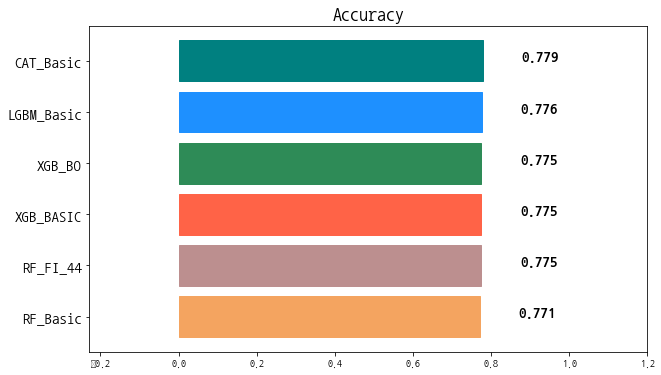

In [183]:
acc_eval('RF_FI_44',pred,y_test) #select feature 후 

### 5.2.2. XGBoost 

In [184]:
from xgboost import XGBClassifier

model = XGBClassifier(
        colsample_bytree= 0.5532036630135703, 
        gamma=1.0, 
        learning_rate= 0.1555825731884874, 
        max_delta_step= 0.09038638082244055, 
        max_depth= 9, 
        min_child_weight= 6.462834212552353, 
        n_estimators= 269, 
        subsample= 0.8740670584510566,
                      n_jobs=-1)

start=time.time()

eval_set = [(x_test, y_test)]

#logloss가 10회 계선되지 않으면 중단하도록 early stopping 설정 n_estimators=100에서는 얼리스탑하지 않음
model.fit(x_train, y_train,early_stopping_rounds=10, eval_metric="logloss", eval_set=eval_set, verbose=True)

(time.time()-start)/60

[0]	validation_0-logloss:0.69009
Will train until validation_0-logloss hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.68673
[2]	validation_0-logloss:0.68384
[3]	validation_0-logloss:0.68095
[4]	validation_0-logloss:0.67772
[5]	validation_0-logloss:0.67481
[6]	validation_0-logloss:0.67184
[7]	validation_0-logloss:0.66887
[8]	validation_0-logloss:0.66582
[9]	validation_0-logloss:0.66283
[10]	validation_0-logloss:0.66021
[11]	validation_0-logloss:0.65730
[12]	validation_0-logloss:0.65461
[13]	validation_0-logloss:0.65223
[14]	validation_0-logloss:0.64953
[15]	validation_0-logloss:0.64677
[16]	validation_0-logloss:0.64416
[17]	validation_0-logloss:0.64152
[18]	validation_0-logloss:0.63942
[19]	validation_0-logloss:0.63707
[20]	validation_0-logloss:0.63468
[21]	validation_0-logloss:0.63229
[22]	validation_0-logloss:0.62975
[23]	validation_0-logloss:0.62752
[24]	validation_0-logloss:0.62511
[25]	validation_0-logloss:0.62285
[26]	validation_0-logloss:0.62049
[27]	validation_0-loglos

0.7532436370849609

In [185]:
pred_XGB = model.predict(x_test)

        model       acc
0    RF_Basic  0.771367
1    RF_FI_44  0.775067
2   XGB_BASIC  0.775400
3      XGB_BO  0.775417
4  LGBM_Basic  0.775867
5   CAT_Basic  0.779133
6   XGB_FI_44  0.780067


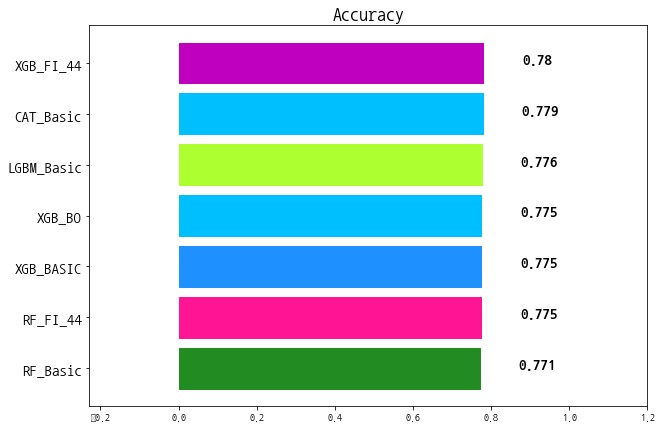

In [186]:
acc_eval('XGB_FI_44',pred_XGB,y_test) #select feature 후 

### 3.2.4 CATBoost

In [187]:
from sklearn.model_selection import cross_val_score
from catboost import CatBoostClassifier

model = CatBoostClassifier()

start=time.time()

#logloss가 10회 계선되지 않으면 중단하도록 early stopping 설정 n_estimators=100에서는 얼리스탑하지 않음
model.fit(x_train, y_train)

(time.time()-start)/60

Learning rate set to 0.052343
0:	learn: 0.6747717	total: 898ms	remaining: 14m 57s
1:	learn: 0.6589573	total: 1.9s	remaining: 15m 45s
2:	learn: 0.6449806	total: 2.99s	remaining: 16m 34s
3:	learn: 0.6330767	total: 3.99s	remaining: 16m 33s
4:	learn: 0.6214593	total: 4.99s	remaining: 16m 33s
5:	learn: 0.6120146	total: 5.79s	remaining: 15m 59s
6:	learn: 0.6027041	total: 6.5s	remaining: 15m 21s
7:	learn: 0.5945684	total: 7.3s	remaining: 15m 5s
8:	learn: 0.5876685	total: 8.19s	remaining: 15m 1s
9:	learn: 0.5810256	total: 9.09s	remaining: 15m
10:	learn: 0.5754221	total: 9.99s	remaining: 14m 58s
11:	learn: 0.5700209	total: 11s	remaining: 15m 5s
12:	learn: 0.5650058	total: 12s	remaining: 15m 10s
13:	learn: 0.5607698	total: 12.9s	remaining: 15m 7s
14:	learn: 0.5564342	total: 13.7s	remaining: 14m 59s
15:	learn: 0.5530028	total: 14.6s	remaining: 14m 57s
16:	learn: 0.5498778	total: 15.5s	remaining: 14m 55s
17:	learn: 0.5471704	total: 16.5s	remaining: 14m 59s
18:	learn: 0.5443387	total: 17.3s	remaini

KeyboardInterrupt: 

In [ ]:
acc_eval('CAT_FI_44',pred,y_test) #select feature 후 

### 3.2.5 LGBM

In [188]:

from lightgbm import LGBMClassifier

start=time.time()
model = LGBMClassifier(n_estimators=300,n_jobs=-1)

eval_set = [(x_test, y_test)]

#logloss가 10회 계선되지 않으면 중단하도록 early stopping 설정 n_estimators=100에서는 얼리스탑하지 않음
model.fit(x_train, y_train,early_stopping_rounds=10,eval_set=eval_set, verbose=True)

[1]	valid_0's binary_logloss: 0.653816
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.631096
[3]	valid_0's binary_logloss: 0.612272
[4]	valid_0's binary_logloss: 0.596394
[5]	valid_0's binary_logloss: 0.583336
[6]	valid_0's binary_logloss: 0.572028
[7]	valid_0's binary_logloss: 0.562248
[8]	valid_0's binary_logloss: 0.553651
[9]	valid_0's binary_logloss: 0.546386
[10]	valid_0's binary_logloss: 0.539961
[11]	valid_0's binary_logloss: 0.534496
[12]	valid_0's binary_logloss: 0.529675
[13]	valid_0's binary_logloss: 0.525449
[14]	valid_0's binary_logloss: 0.521446
[15]	valid_0's binary_logloss: 0.518048
[16]	valid_0's binary_logloss: 0.514594
[17]	valid_0's binary_logloss: 0.511254
[18]	valid_0's binary_logloss: 0.508671
[19]	valid_0's binary_logloss: 0.506243
[20]	valid_0's binary_logloss: 0.504311
[21]	valid_0's binary_logloss: 0.501989
[22]	valid_0's binary_logloss: 0.500202
[23]	valid_0's binary_logloss: 0.498108
[24]	valid_0's binary_loglos

LGBMClassifier(n_estimators=300)

In [189]:
(time.time()-start)/60

0.06516526540120443

In [190]:
pred = model.predict(x_test)

        model       acc
0    RF_Basic  0.771367
1    RF_FI_44  0.775067
2   XGB_BASIC  0.775400
3      XGB_BO  0.775417
4  LGBM_Basic  0.775867
5  LGBM_FI_44  0.777533
6   CAT_Basic  0.779133
7   XGB_FI_44  0.780067


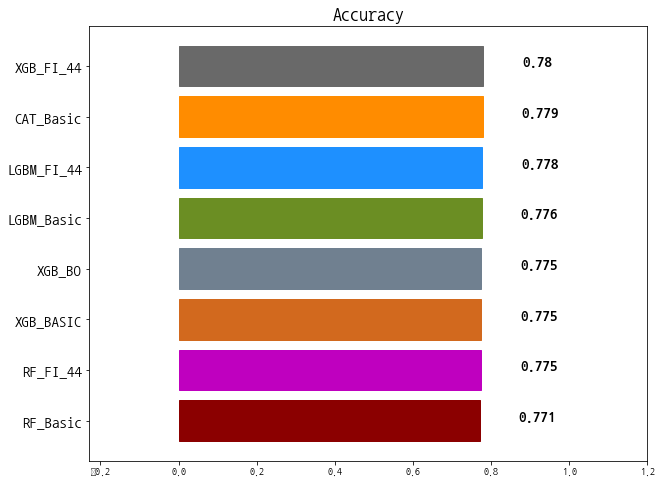

In [191]:
acc_eval('LGBM_FI_44',pred,y_test) #select feature 후 

# 6.차별화 알고리즘

## 6.1 보더라인(Boarder Line 명확화)

학습데이터(train_data)를 train/ test로 분리하여 모델의 평가를 할때,  

지속적으로 예측값과 실제값이 불일치하는 데이터는 Decision Boundary 를 불명확하게 하는 요소가 될 수 있으며, 예측 성능을 떨어뜨림

이런 데이터를 클러스터링하여 분류가 잘안되는 데이터를 확인하고, Decision Boundary을 명확하게 함으로써 예측 성능을 올릴 수 있음


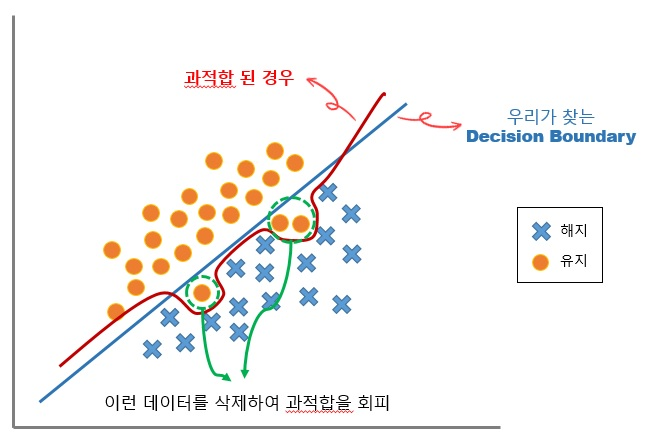

In [192]:
Image('image/deci.jpg')

## 6.2. DBSCAN으로 클러스터링 해서 삭제하는 방법 테스트

### 6.2.1. 알고리즘 컨셉 설명

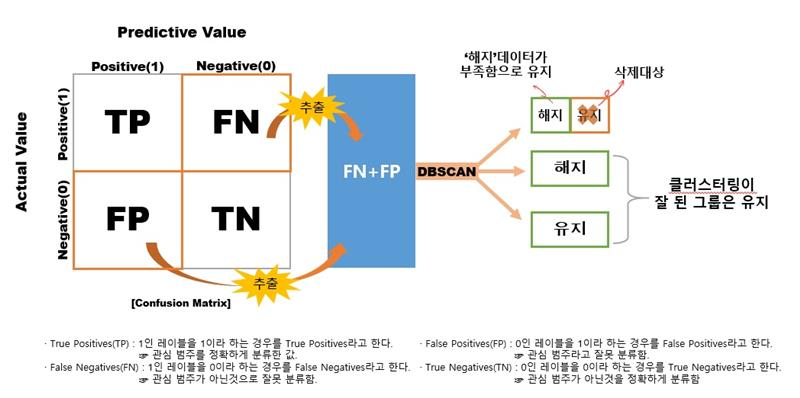

In [193]:
Image('image/DBSCAN.jpg')

### 6.2.2 One-Hot Encoding

- label encoding 대상인 le_columns가 원핫 인코딩 대상임
- 범주가 넓은 항목을 원핫인코딩을 하게되면 컬럼수가 많이 늘어나고 모델이 복잡해져서 트리계열 모델에서 성능이 낮아짐 
- 원핫 처리하기전에 의미없는 컬럼을 줄이거나 원핫 후 차원축소 필요함

원핫인코딩을 할때 train과 test의 범주가 다를 수 있음. 이 경우 train과 test의 범주를 합쳐서 fit을 하면 안됨(test 데이터 인입 시점에는 해당 카테고리를 알수 없음) 아래와 같이 적용하며, test에만 존재하는 범주인 경우 0/0/0...0/0 으로 들어가게됨

In [248]:
#라벨 인코딩 대상 컬럼 찾기
le_columns=[]
for i in train_data.columns:
    if i[-2:]=='cd' or i[-2:]=='yn':
        le_columns.append(i)

In [249]:
from sklearn.preprocessing import OneHotEncoder

# LabelEncoder를 객체로 생성한 후 , fit( ) 과 transform( ) 으로 label 인코딩 수행. 
enc = OneHotEncoder(handle_unknown = 'ignore',sparse=False)
enc.fit(train_data[le_columns])

enc.transform(train_data[le_columns])

array([[1., 0., 1., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 1., 0.],
       ...,
       [1., 0., 1., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 1., 0.],
       [1., 0., 1., ..., 0., 1., 0.]])

In [250]:
enc.transform(test_data[le_columns])

array([[1., 0., 1., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 1., 0.],
       ...,
       [1., 0., 1., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 1., 0.],
       [1., 0., 1., ..., 0., 1., 0.]])

- One-Hot Encoding 결과를 적용함

In [251]:
train_data_OH = pd.concat([train_data,pd.DataFrame(enc.transform(train_data[le_columns]))],axis=1)

test_data_OH = pd.concat([test_data,pd.DataFrame(enc.transform(test_data[le_columns]))],axis=1)

train_data_OH.drop(le_columns,axis=1,inplace=True)

test_data_OH.drop(le_columns,axis=1,inplace=True)

### 6.2.3 데이터 분할하여 DBSCAN 검증

X_test의 예측 결과를 검증할 수 없으므로 X_train을 train/validation/test 셋으로 분리하여 검증에 이용한다

train_data/test_data를 아래와 같이 분리한다.

- X_train/Y_train  --> 최종 학습 데이터 (0.9)
- X_test/Y_test   --> 최종 테스트 데이터 (0.1)


X_train/Y_train을 아래와 같이 분리한다
- x_train/y_train  --> 검증용 학습 데이터 (0.75)
- x_test/y_test   --> 검증용 테스트 데이터 (0.25)
 


In [252]:
from sklearn.model_selection import train_test_split

In [253]:
X_train, X_test, Y_train, Y_test = train_test_split(train_data_OH.drop('status',1),train_data_OH['status'],random_state=21, test_size=0.1)

In [254]:
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((54000, 525), (6000, 525), (54000,), (6000,))

In [255]:
x_train, x_test, y_train, y_test = train_test_split(X_train,Y_train,random_state=21)

In [256]:
x_train.shape, x_test.shape, X_test.shape, y_train.shape, y_test.shape, Y_test.shape



((40500, 525), (13500, 525), (6000, 525), (40500,), (13500,), (6000,))

### 6.2.4 차원축소

- PCA 차원 축소

In [257]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2) # 주성분을 몇개로 할지 결정
printcipalComponents = pca.fit_transform(x_train)
x_train = pd.DataFrame(data=printcipalComponents)
printcipalComponents = pca.transform(x_test)
x_test = pd.DataFrame(data=printcipalComponents)
printcipalComponents = pca.transform(X_train)
X_train = pd.DataFrame(data=printcipalComponents)
printcipalComponents = pca.transform(X_test)
X_test = pd.DataFrame(data=printcipalComponents)
# 주성분으로 이루어진 데이터 프레임 구성

In [258]:
x_train.shape, x_test.shape, X_test.shape,X_train.shape

((40500, 2), (13500, 2), (6000, 2), (54000, 2))

In [259]:
#Index가 초기화 되므로 유지시켜줌
x_train.index=y_train.index
x_test.index=y_test.index
X_train.index=Y_train.index
X_test.index=Y_test.index

### 6.2.5 검증용 모델 생성

y_test 예측

In [260]:
from xgboost import XGBClassifier

model = XGBClassifier(
        colsample_bytree= 0.5532036630135703, 
        gamma=1.0, 
        learning_rate= 0.1555825731884874, 
        max_delta_step= 0.09038638082244055, 
        max_depth= 9, 
        min_child_weight= 6.462834212552353, 
        n_estimators= 269, 
        subsample= 0.8740670584510566,
                      n_jobs=-1)

start=time.time()

eval_set = [(x_test, y_test)]

#logloss가 10회 계선되지 않으면 중단하도록 early stopping 설정 n_estimators=100에서는 얼리스탑하지 않음
model.fit(x_train, y_train,early_stopping_rounds=10, eval_metric="logloss", eval_set=eval_set, verbose=True)

(time.time()-start)/60

[0]	validation_0-logloss:0.69197
Will train until validation_0-logloss hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.69087
[2]	validation_0-logloss:0.68980
[3]	validation_0-logloss:0.68869
[4]	validation_0-logloss:0.68723
[5]	validation_0-logloss:0.68618
[6]	validation_0-logloss:0.68478
[7]	validation_0-logloss:0.68388
[8]	validation_0-logloss:0.68229
[9]	validation_0-logloss:0.68086
[10]	validation_0-logloss:0.67939
[11]	validation_0-logloss:0.67861
[12]	validation_0-logloss:0.67721
[13]	validation_0-logloss:0.67643
[14]	validation_0-logloss:0.67564
[15]	validation_0-logloss:0.67434
[16]	validation_0-logloss:0.67304
[17]	validation_0-logloss:0.67184
[18]	validation_0-logloss:0.67115
[19]	validation_0-logloss:0.67051
[20]	validation_0-logloss:0.66986
[21]	validation_0-logloss:0.66931
[22]	validation_0-logloss:0.66813
[23]	validation_0-logloss:0.66700
[24]	validation_0-logloss:0.66595
[25]	validation_0-logloss:0.66541
[26]	validation_0-logloss:0.66437
[27]	validation_0-loglos

0.0631653865178426

In [261]:
pred=model.predict(x_test)

In [262]:
(pred==y_test).mean()

0.6335555555555555

- Y_test 예측

In [263]:
from xgboost import XGBClassifier

model = XGBClassifier(
        colsample_bytree= 0.5532036630135703, 
        gamma=1.0, 
        learning_rate= 0.1555825731884874, 
        max_delta_step= 0.09038638082244055, 
        max_depth= 9, 
        min_child_weight= 6.462834212552353, 
        n_estimators= 269, 
        subsample= 0.8740670584510566,
                      n_jobs=-1)

start=time.time()

eval_set = [(X_test, Y_test)]

#logloss가 10회 계선되지 않으면 중단하도록 early stopping 설정 n_estimators=100에서는 얼리스탑하지 않음
model.fit(X_train, Y_train,early_stopping_rounds=10, eval_metric="logloss", eval_set=eval_set, verbose=True)

(time.time()-start)/60

[0]	validation_0-logloss:0.69197
Will train until validation_0-logloss hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.69041
[2]	validation_0-logloss:0.68888
[3]	validation_0-logloss:0.68788
[4]	validation_0-logloss:0.68641
[5]	validation_0-logloss:0.68465
[6]	validation_0-logloss:0.68287
[7]	validation_0-logloss:0.68121
[8]	validation_0-logloss:0.68011
[9]	validation_0-logloss:0.67846
[10]	validation_0-logloss:0.67744
[11]	validation_0-logloss:0.67644
[12]	validation_0-logloss:0.67492
[13]	validation_0-logloss:0.67400
[14]	validation_0-logloss:0.67255
[15]	validation_0-logloss:0.67170
[16]	validation_0-logloss:0.67090
[17]	validation_0-logloss:0.66951
[18]	validation_0-logloss:0.66815
[19]	validation_0-logloss:0.66682
[20]	validation_0-logloss:0.66563
[21]	validation_0-logloss:0.66447
[22]	validation_0-logloss:0.66336
[23]	validation_0-logloss:0.66270
[24]	validation_0-logloss:0.66162
[25]	validation_0-logloss:0.66061
[26]	validation_0-logloss:0.65965
[27]	validation_0-loglos

0.08630957206090291

In [264]:
Y_pred=model.predict(X_test)

In [265]:
(Y_pred==Y_test).mean()

0.6421666666666667

### 6.2.2 클러스터링 대상을 저장함

In [266]:
feature = x_test[pred!=y_test]

In [267]:
#index를 따로 빼준다
feature.reset_index(inplace=True)

In [268]:
feature.head()

,index,0,1
0,8001,-25.696139,-1.756991
1,22894,-25.112041,-2.756664
2,17798,-20.179602,-2.759972
3,17021,-24.909460,0.231848
4,6527,-25.455119,0.229001


- DBSCAN의 하이퍼파라미터는 튜닝이 필요함

    eps : 군집의 반경
    min_samples : 군집의 최소 크기

In [269]:
from sklearn.cluster import DBSCAN
import matplotlib.pyplot  as plt
import seaborn as sns

# create model and prediction
model = DBSCAN(eps=0.4,min_samples=10)
predict = pd.DataFrame(model.fit_predict(feature.iloc[:,1:]))
predict.columns=['predict']

# concatenate labels to df as a new column
r = pd.concat([feature.iloc[:,1:],predict],axis=1)

print(r)

              0         1  predict
0    -25.696139 -1.756991        0
1    -25.112041 -2.756664        1
2    -20.179602 -2.759972        1
3    -24.909460  0.231848        2
4    -25.455119  0.229001        2
...         ...       ...      ...
4942 -26.335585 -1.756314        0
4943 -29.662471 -1.761626        0
4944 -22.077392 -0.766861        3
4945 -24.817619 -2.754478        1
4946 -24.783910 -2.754312        1

[4947 rows x 3 columns]


In [270]:
r.groupby(['predict']).count()

,0,1
predict,,
-1,451,451
0,1857,1857
1,1177,1177
2,418,418
3,743,743
4,167,167
5,73,73
6,19,19
7,12,12


클러스터링 결과를 검증

In [271]:
DBS_val=r.copy()

DBS_val.set_index(feature['index'],inplace=True)

#status를 추출해서 DBS_val 에 status를 붙여준다
DBS_val=pd.concat([DBS_val,train_data.iloc[DBS_val.index,0]],axis=1)

In [272]:
DBS_val

,0,1,predict,status
8001,-25.696139,-1.756991,0,1
22894,-25.112041,-2.756664,1,1
17798,-20.179602,-2.759972,1,1
17021,-24.909460,0.231848,2,0
6527,-25.455119,0.229001,2,0
...,...,...,...,...
29780,-26.335585,-1.756314,0,0
53981,-29.662471,-1.761626,0,0
57853,-22.077392,-0.766861,3,1
14564,-24.817619,-2.754478,1,1


In [273]:
#groupby로 각 DBSCAN의 클러스터가 의미가 있는지 확인한다 (3,20)
DBS_stat=pd.DataFrame(DBS_val.groupby(['predict','status'])[0].count())

DBS_stat

0
predict status      
-1      0        323
        1        128
 0      0       1222
        1        635
 1      0        240
        1        937
 2      0        385
        1         33
 3      0        611
        1        132
 4      0        166
        1          1
 5      0         69
        1          4
 6      0          8
        1         11
 7      0         12
 8      0         10
        1         10
 9      0          4
        1          6

- 위에서 분류가 제대로 안되는 status 1인 유지 건을 삭제한다(Drop_val에서 stauts=1인 대상을 삭제함)

  단 predict가 1인 경우는 1로 예측하는 case로 보이므로 그대로 둔다.

- status==1인 대상을 삭제함

In [274]:
not_pred_1=DBS_val[DBS_val['predict']!=1] 

In [275]:
not_pred_1_0=not_pred_1[not_pred_1['predict']!=0] 

- 삭제 대상을 Index로 만듬

In [276]:
del_idx=not_pred_1_0[not_pred_1_0['status']==1].index
del_idx

Int64Index([44419, 18255, 21523, 23489, 43172, 29412, 34507, 21273, 25431,
            32783,
            ...
            53844, 36491, 19862, 39335, 41904, 29293, 49335,  8229, 43564,
            57853],
           dtype='int64', length=325)

- drop_idx를 삭제함

In [280]:
X_train.drop(del_idx,axis=0,inplace=True)
Y_train.drop(del_idx,axis=0,inplace=True)

다시 데이터 셋을 분리함

In [281]:
from sklearn.model_selection import train_test_split

In [282]:
x_train, x_test, y_train, y_test = train_test_split(X_train,Y_train,random_state=21)

In [283]:
x_train.shape, x_test.shape, X_test.shape, y_train.shape, y_test.shape, Y_test.shape



((40256, 2), (13419, 2), (6000, 2), (40256,), (13419,), (6000,))

- 현재 성능이 가장 잘 나오는 모델로 예측함

In [284]:
from xgboost import XGBClassifier

model = XGBClassifier(
        colsample_bytree= 0.5532036630135703, 
        gamma=1.0, 
        learning_rate= 0.1555825731884874, 
        max_delta_step= 0.09038638082244055, 
        max_depth= 9, 
        min_child_weight= 6.462834212552353, 
        n_estimators= 269, 
        subsample= 0.8740670584510566,
                      n_jobs=-1)

start=time.time()

eval_set = [(x_test, y_test)]

#logloss가 10회 계선되지 않으면 중단하도록 early stopping 설정 n_estimators=100에서는 얼리스탑하지 않음
model.fit(x_train, y_train,early_stopping_rounds=10, eval_metric="logloss", eval_set=eval_set, verbose=True)

(time.time()-start)/60

[0]	validation_0-logloss:0.69202
Will train until validation_0-logloss hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.69097
[2]	validation_0-logloss:0.68995
[3]	validation_0-logloss:0.68901
[4]	validation_0-logloss:0.68757
[5]	validation_0-logloss:0.68675
[6]	validation_0-logloss:0.68585
[7]	validation_0-logloss:0.68504
[8]	validation_0-logloss:0.68349
[9]	validation_0-logloss:0.68208
[10]	validation_0-logloss:0.68065
[11]	validation_0-logloss:0.67997
[12]	validation_0-logloss:0.67922
[13]	validation_0-logloss:0.67856
[14]	validation_0-logloss:0.67721
[15]	validation_0-logloss:0.67596
[16]	validation_0-logloss:0.67473
[17]	validation_0-logloss:0.67416
[18]	validation_0-logloss:0.67354
[19]	validation_0-logloss:0.67313
[20]	validation_0-logloss:0.67192
[21]	validation_0-logloss:0.67084
[22]	validation_0-logloss:0.66977
[23]	validation_0-logloss:0.66875
[24]	validation_0-logloss:0.66831
[25]	validation_0-logloss:0.66735
[26]	validation_0-logloss:0.66645
[27]	validation_0-loglos

0.05988669395446777

In [285]:
pred=model.predict(x_test)

In [286]:
(pred==y_test).mean()

0.6323123928757731

단, 예측 못하는 것을 뺐으니, 뺀 범위에서 예측 성능이 크게 올라가는 것은 당연한 것임. 그러나 train_data도 train/valid/test로 나누어 검증했을 때도 성능이 향상됨

In [287]:
model = XGBClassifier(
        colsample_bytree= 0.5532036630135703, 
        gamma=1.0, 
        learning_rate= 0.1555825731884874, 
        max_delta_step= 0.09038638082244055, 
        max_depth= 9, 
        min_child_weight= 6.462834212552353, 
        n_estimators= 269, 
        subsample= 0.8740670584510566, n_jobs=-1)

model.fit(X_train,Y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5532036630135703,
              gamma=1.0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.1555825731884874,
              max_delta_step=0.09038638082244055, max_depth=9,
              min_child_weight=6.462834212552353, missing=nan,
              monotone_constraints='()', n_estimators=269, n_jobs=-1,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=0.8740670584510566,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [288]:
pred=model.predict(X_test)

In [289]:
(pred==Y_test).mean()

0.642

## 6.3 실제 데이터에 적용 

### 6.3.1 데이터 재분할

In [295]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(train_data_OH.drop('status',1),train_data_OH['status'],random_state=21)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((45000, 525), (15000, 525), (45000,), (15000,))

### 3.0.2 실제 예측을 위한 데이터 or k겹교차일때 데이터

In [296]:
X_train = train_data_OH.drop('status',axis=1)

Y_train = train_data_OH['status']

X_test = test_data_OH

X_train.shape, X_test.shape, Y_train.shape #Y_test는 없음

((60000, 525), (10000, 525), (60000,))

### 6.2.3 차원축소

- PCA 차원 축소

In [297]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2) # 주성분을 몇개로 할지 결정
printcipalComponents = pca.fit_transform(x_train)
x_train = pd.DataFrame(data=printcipalComponents)
printcipalComponents = pca.transform(x_test)
x_test = pd.DataFrame(data=printcipalComponents)
printcipalComponents = pca.transform(X_train)
X_train = pd.DataFrame(data=printcipalComponents)
printcipalComponents = pca.transform(X_test)
X_test = pd.DataFrame(data=printcipalComponents)
# 주성분으로 이루어진 데이터 프레임 구성

In [302]:
x_train.shape, y_train.shape,x_test.shape,y_test.shape, X_test.shape,X_train.shape,Y_train.shape

((45000, 2), (45000,), (15000, 2), (15000,), (10000, 2), (60000, 2), (60000,))

In [303]:
x_train.index=y_train.index
x_test.index=y_test.index
X_train.index=Y_train.index


In [304]:
X_test

,0,1
0,-23.784490,0.318914
1,-36.989988,-1.672671
2,-23.550071,1.313980
3,-23.646774,-1.668540
4,-23.043833,0.315312
...,...,...
9995,-23.062372,-2.663910
9996,-22.044380,-2.669100
9997,-23.454724,-1.669717
9998,-22.925199,0.318838


### 6.2.4 검증용 모델 생성

y_test 예측

In [305]:
from xgboost import XGBClassifier

model = XGBClassifier(
        colsample_bytree= 0.5532036630135703, 
        gamma=1.0, 
        learning_rate= 0.1555825731884874, 
        max_delta_step= 0.09038638082244055, 
        max_depth= 9, 
        min_child_weight= 6.462834212552353, 
        n_estimators= 269, 
        subsample= 0.8740670584510566,
                      n_jobs=-1)

start=time.time()

eval_set = [(x_test, y_test)]

#logloss가 10회 계선되지 않으면 중단하도록 early stopping 설정 n_estimators=100에서는 얼리스탑하지 않음
model.fit(x_train, y_train,early_stopping_rounds=10, eval_metric="logloss", eval_set=eval_set, verbose=True)

(time.time()-start)/60

[0]	validation_0-logloss:0.69211
Will train until validation_0-logloss hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.69051
[2]	validation_0-logloss:0.68954
[3]	validation_0-logloss:0.68805
[4]	validation_0-logloss:0.68654
[5]	validation_0-logloss:0.68512
[6]	validation_0-logloss:0.68430
[7]	validation_0-logloss:0.68273
[8]	validation_0-logloss:0.68112
[9]	validation_0-logloss:0.68019
[10]	validation_0-logloss:0.67931
[11]	validation_0-logloss:0.67782
[12]	validation_0-logloss:0.67698
[13]	validation_0-logloss:0.67632
[14]	validation_0-logloss:0.67484
[15]	validation_0-logloss:0.67421
[16]	validation_0-logloss:0.67283
[17]	validation_0-logloss:0.67153
[18]	validation_0-logloss:0.67086
[19]	validation_0-logloss:0.67029
[20]	validation_0-logloss:0.66899
[21]	validation_0-logloss:0.66781
[22]	validation_0-logloss:0.66728
[23]	validation_0-logloss:0.66607
[24]	validation_0-logloss:0.66501
[25]	validation_0-logloss:0.66449
[26]	validation_0-logloss:0.66403
[27]	validation_0-loglos

0.0803620974222819

In [306]:
pred=model.predict(x_test)

In [307]:
(pred==y_test).mean()

0.6402666666666667

### 6.2.2 클러스터링 대상을 저장함

In [308]:
feature = x_test[pred!=y_test]

In [309]:
#index를 따로 빼준다
feature.reset_index(inplace=True)

In [310]:
feature.head()

,index,0,1
0,30807,-20.401228,-1.676489
1,34300,-24.801116,-2.669202
2,53799,-22.798606,0.316401
3,18419,-22.657070,-2.682864
4,27462,-22.871167,-1.668645


In [311]:
from sklearn.cluster import DBSCAN
import matplotlib.pyplot  as plt
import seaborn as sns

# create model and prediction
model = DBSCAN(eps=0.4,min_samples=10)
predict = pd.DataFrame(model.fit_predict(feature.iloc[:,1:]))
predict.columns=['predict']

# concatenate labels to df as a new column
r = pd.concat([feature.iloc[:,1:],predict],axis=1)

print(r)

              0         1  predict
0    -20.401228 -1.676489        0
1    -24.801116 -2.669202        1
2    -22.798606  0.316401        2
3    -22.657070 -2.682864        1
4    -22.871167 -1.668645        0
...         ...       ...      ...
5391 -23.414058 -2.668654        1
5392 -21.013567 -2.671606        1
5393 -24.386881 -1.670299        0
5394 -22.807346 -1.675178        0
5395 -22.413689 -1.671663        0

[5396 rows x 3 columns]


In [312]:
r.groupby(['predict']).count()

,0,1
predict,,
-1,470,470
0,2068,2068
1,1229,1229
2,426,426
3,903,903
4,12,12
5,207,207
6,50,50
7,16,16


클러스터링 결과를 검증

In [313]:
DBS_val=r.copy()

DBS_val.set_index(feature['index'],inplace=True)

#status를 추출해서 DBS_val 에 status를 붙여준다
DBS_val=pd.concat([DBS_val,train_data.iloc[DBS_val.index,0]],axis=1)

In [314]:
DBS_val

,0,1,predict,status
30807,-20.401228,-1.676489,0,1
34300,-24.801116,-2.669202,1,0
53799,-22.798606,0.316401,2,0
18419,-22.657070,-2.682864,1,1
27462,-22.871167,-1.668645,0,0
...,...,...,...,...
18511,-23.414058,-2.668654,1,1
39274,-21.013567,-2.671606,1,0
27572,-24.386881,-1.670299,0,0
17366,-22.807346,-1.675178,0,0


In [315]:
#groupby로 각 DBSCAN의 클러스터가 의미가 있는지 확인한다 (3,20)
DBS_stat=pd.DataFrame(DBS_val.groupby(['predict','status'])[0].count())

DBS_stat

0
predict status      
-1      0        323
        1        147
 0      0       1359
        1        709
 1      0        298
        1        931
 2      0        387
        1         39
 3      0        751
        1        152
 4      0          3
        1          9
 5      0        193
        1         14
 6      0         46
        1          4
 7      0         15
        1          1
 8      0         12
        1          3

위에서 분류가 제대로 안되는 status 1인 유지 건을 삭제한다(Drop_val에서 stauts=1인 대상을 삭제함)

단 predict가 1인 경우는 1로 예측하는 case로 보이므로 그대로 둔다.

status==1인 대상을 삭제함

In [316]:
not_pred_1=DBS_val[DBS_val['predict']!=1] 

In [317]:
not_pred_1_0=not_pred_1[not_pred_1['predict']!=0] 

In [318]:
del_idx=not_pred_1_0[not_pred_1_0['status']==1].index
del_idx

Int64Index([41463, 46449, 57561, 16346, 53542, 23990, 27545, 55770, 30935,
             4503,
            ...
            47044, 24242, 36095, 42140, 14055, 27181, 53948, 38945, 32172,
            10422],
           dtype='int64', length=369)

drop 대상 생성

In [319]:
drop_data=pd.concat([r,feature['index']],axis=1)
drop_data

,0,1,predict,index
0,-20.401228,-1.676489,0,30807
1,-24.801116,-2.669202,1,34300
2,-22.798606,0.316401,2,53799
3,-22.657070,-2.682864,1,18419
4,-22.871167,-1.668645,0,27462
...,...,...,...,...
5391,-23.414058,-2.668654,1,18511
5392,-21.013567,-2.671606,1,39274
5393,-24.386881,-1.670299,0,27572
5394,-22.807346,-1.675178,0,17366


In [320]:
#index를 원래대로 돌림
drop_data.index=drop_data['index']

In [321]:
#index를 원래대로 돌림
drop_data.set_index('index',inplace=True)
drop_data

,0,1,predict
index,,,
30807,-20.401228,-1.676489,0
34300,-24.801116,-2.669202,1
53799,-22.798606,0.316401,2
18419,-22.657070,-2.682864,1
27462,-22.871167,-1.668645,0
...,...,...,...
18511,-23.414058,-2.668654,1
39274,-21.013567,-2.671606,1
27572,-24.386881,-1.670299,0


In [322]:
del_idx

Int64Index([41463, 46449, 57561, 16346, 53542, 23990, 27545, 55770, 30935,
             4503,
            ...
            47044, 24242, 36095, 42140, 14055, 27181, 53948, 38945, 32172,
            10422],
           dtype='int64', length=369)

In [323]:
#drop_idx를 삭제함
train_data_OH.drop(del_idx,axis=0,inplace=True)

다시 데이터 셋을 분리함

In [324]:
from sklearn.model_selection import train_test_split

In [325]:
train_data_OH.shape, test_data_OH.shape

((59631, 526), (10000, 525))

### 3.0.1 일단 당장의 모델은 train 데이터를 분할하여 검증하면서 진행한다

In [326]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(train_data_OH.drop('status',1),train_data_OH['status'],random_state=21)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((44723, 525), (14908, 525), (44723,), (14908,))

### 3.0.2 실제 예측을 위한 데이터 or k겹교차일때 데이터

In [327]:
X_train = train_data_OH.drop('status',axis=1)

Y_train = train_data_OH['status']

X_test = test_data_OH

X_train.shape, X_test.shape, Y_train.shape #Y_test는 없음

((59631, 525), (10000, 525), (59631,))

In [328]:
x_train.shape, x_test.shape, X_test.shape, y_train.shape, y_test.shape, Y_test.shape



((44723, 525), (14908, 525), (10000, 525), (44723,), (14908,), (6000,))

- 현재 성능이 가장 잘 나오는 모델로 예측함

In [329]:
from xgboost import XGBClassifier

model = XGBClassifier(
        colsample_bytree= 0.5532036630135703, 
        gamma=1.0, 
        learning_rate= 0.1555825731884874, 
        max_delta_step= 0.09038638082244055, 
        max_depth= 9, 
        min_child_weight= 6.462834212552353, 
        n_estimators= 269, 
        subsample= 0.8740670584510566,
                      n_jobs=-1)


start=time.time()

eval_set = [(x_test, y_test)]

#logloss가 10회 계선되지 않으면 중단하도록 early stopping 설정 n_estimators=100에서는 얼리스탑하지 않음
model.fit(x_train, y_train,early_stopping_rounds=10, eval_metric="logloss", eval_set=eval_set, verbose=True)

(time.time()-start)/60

[0]	validation_0-logloss:0.68981
Will train until validation_0-logloss hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.68676
[2]	validation_0-logloss:0.68334
[3]	validation_0-logloss:0.68043
[4]	validation_0-logloss:0.67725
[5]	validation_0-logloss:0.67431
[6]	validation_0-logloss:0.67147
[7]	validation_0-logloss:0.66832
[8]	validation_0-logloss:0.66541
[9]	validation_0-logloss:0.66270
[10]	validation_0-logloss:0.65966
[11]	validation_0-logloss:0.65662
[12]	validation_0-logloss:0.65374
[13]	validation_0-logloss:0.65118
[14]	validation_0-logloss:0.64815
[15]	validation_0-logloss:0.64538
[16]	validation_0-logloss:0.64252
[17]	validation_0-logloss:0.63965
[18]	validation_0-logloss:0.63683
[19]	validation_0-logloss:0.63421
[20]	validation_0-logloss:0.63162
[21]	validation_0-logloss:0.62905
[22]	validation_0-logloss:0.62647
[23]	validation_0-logloss:0.62384
[24]	validation_0-logloss:0.62133
[25]	validation_0-logloss:0.61879
[26]	validation_0-logloss:0.61644
[27]	validation_0-loglos

3.6646560549736025

In [335]:
pred=model.predict(x_test)

In [336]:
(pred==y_test).mean()

0.7735444056882211

- 예측 못하는 것을 뺐으니, 뺀 범위에서 예측 성능이 크게 올라가는 것은 당연한 것임. 그러나 train_data도 train/valid/test로 나누어 검증했을 때도 성능이 향상되는 것을 확인했으므로 해당 데이터는 원본에서도 삭제함

- 원본데이터를 불러옴

In [330]:
#(1) 원본 데이터
train_data= pd.read_csv(sacp_framework.config.data_dir + '/ep1_train_t1_t2.csv')

#(1) 원본 데이터
test_data= pd.read_csv(sacp_framework.config.data_dir + '/ep1_test_t1_t2.csv')

In [331]:
#drop_idx를 삭제함
train_data.drop(del_idx,axis=0,inplace=True)

In [332]:
train_data

,id,status,new_date,mob_trmn_cnt,int_trmn_cnt,mob_cont_cnt,int_cont_cnt,cust_ctg_type_itg_cd,sex_type_itg_cd,vip_adm_tag_itg_cd,olcb_sbsc_yn,inet_sbsc_yn,soip_sbsc_yn,iptv_sbsc_yn,pstn_sbsc_yn,wibro_sbsc_yn,mphon_sbsc_yn,comb_prod_sbsc_yn,efct_mphon_sbsc_cascnt,efct_pstn_sbsc_cascnt,efct_soip_sbsc_cascnt,efct_inet_sbsc_cascnt,efct_iptv_sbsc_cascnt,efct_wibro_sbsc_cascnt,dt_stop_yn,inet_light_sbsc_yn,mphon_comb_yn,inet_comb_yn,iptv_comb_yn,mphon_aftmn_eperd_itg_cd,inet_aftmn_eperd_itg_cd,inet_trmn_why_itg_cd,mphon_trmn_why_itg_cd,npay_yn,rmonth_pstn_bill_amt,r3m_avg_bill_amt,r6m_inet_pssn_comb_yn,r3m_mphon_avg_arpu_amt,r3m_inet_avg_arpu_amt,r6m_mphon_avg_arpu_amt,r6m_inet_avg_arpu_amt,tngr_sbscr_exist_hshld_yn,smph_use_yn,kids_wless_adtn_svc_sbsc_yn,kids_wrlin_adtn_svc_sbsc_yn,iptv_infn_conts_use_yn,inet_engt_exp_rperd_itg_cd,mphon_engt_exp_rperd_itg_cd,iptv_engt_exp_rperd_itg_cd,kibot_sbsc_yn,pad_use_yn,r3m_ppv_avg_use_amt,r6m_iptv_first_ppv_use_yn,voc1_daycnt,voc2_daycnt,voc3_daycnt,voc4_daycnt,voc5_daycnt,voc6_daycnt,voc7_daycnt,voc8_daycnt,voc9_daycnt,voc10_daycnt,voc11_daycnt,voc12_daycnt,trmn_voc_yn,voc_sum_cnt,day_sum_cnt
0,E1000001,Y,20170421,0,0,1,0,10001,F,_,Y,Y,N,Y,N,N,Y,Y,1.0,0.0,0.0,1.0,2.0,0.0,N,N,Y,Y,Y,_,_,_,_,Y,0.0,127237.000,Y,40393.333,21780.000,41749.517,21774.500,N,Y,N,N,N,R09,R12,R09,N,N,0.0,N,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,1
1,E1000002,N,20131203,0,0,2,0,10001,M,BM,N,N,N,N,N,N,Y,N,1.0,0.0,0.0,0.0,0.0,0.0,N,N,N,N,N,_,_,_,_,N,0.0,36700.000,N,34460.500,0.000,35569.213,0.000,N,Y,N,N,N,_,R06,_,N,N,0.0,N,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,1,1
2,E1000003,N,20170731,0,0,1,1,10001,M,_,N,Y,N,Y,Y,N,N,Y,0.0,1.0,0.0,1.0,2.0,0.0,N,N,Y,Y,Y,_,_,_,_,N,1100.0,30000.000,Y,0.000,14300.000,0.000,14300.000,N,N,N,N,N,000,_,000,N,N,0.0,N,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,1,1
3,E1000004,Y,20090930,0,0,4,1,10001,F,BM,Y,Y,N,Y,N,N,Y,Y,1.0,0.0,0.0,1.0,1.0,0.0,N,N,Y,Y,Y,_,_,_,_,Y,0.0,72767.667,Y,34747.417,27500.000,34714.917,27500.000,N,Y,N,N,N,P36,R11,P36,N,N,0.0,N,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0,2,2
4,E1000005,N,20151121,0,0,1,1,10001,F,BM,Y,Y,N,Y,Y,N,Y,Y,2.0,1.0,0.0,2.0,2.0,0.0,Y,N,Y,Y,Y,_,_,_,_,N,950.0,103365.333,Y,59856.279,27041.500,58386.112,25621.700,N,Y,N,N,N,R27,R22,R27,N,N,0.0,N,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,E1059996,N,20190125,0,0,0,1,10005,_,_,Y,Y,Y,N,Y,N,N,Y,0.0,1.0,4.0,2.0,0.0,0.0,N,N,N,Y,N,_,_,_,_,N,10281.0,145760.667,Y,0.000,70400.667,0.000,70400.333,N,N,N,N,N,R18,_,_,N,N,0.0,N,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,1,1
59996,E1059997,Y,20170413,0,0,1,0,10001,F,BM,Y,Y,N,Y,N,N,Y,Y,2.0,0.0,0.0,1.0,2.0,0.0,N,N,Y,Y,Y,_,_,_,_,N,0.0,199696.667,Y,71500.000,16172.000,84959.549,16172.000,N,Y,N,N,N,P21,R01,P21,N,N,0.0,N,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,1
59997,E1059998,N,20161030,0,0,2,1,10001,F,_,Y,N,N,N,Y,N,Y,Y,1.0,1.0,0.0,0.0,0.0,0.0,N,N,Y,Y,Y,_,_,_,_,N,5760.0,28070.333,N,22602.167,0.000,22551.083,0.000,N,Y,N,N,N,_,R02,_,N,N,0.0,N,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,1,1
59998,E1059999,N,20160929,0,0,1,1,10001,M,_,Y,Y,N,Y,N,N,N,Y,0.0,0.0,0.0,1.0,1.0,0.0,N,N,Y,Y,Y,_,_,_,_,N,0.0,34915.000,Y,0.000,21618.000,0.000,21618.000,N,N,N,N,N,P10,_,P10,N,N,0.0,N,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,1,3,1


In [333]:
#저장함
train_data.to_csv(sacp_framework.config.data_dir + '/ep1_train_t1_t2_DB.csv',header=True, index=False, encoding='utf-8')

## 6.2 테스트데이터를 학습에 활용 (보팅 + 스태킹 응용)

### 6.2.1. 알고리즘 컨셉설명

- 여러개의 모델이 test_data에 대해 모두 동일한 결과를 예측하는 경우, 해당 데이터는 정답일 가능성이 높음
- 이런 데이터를 train_data에 추가하여 학습량을 늘림으로서 모델 성능을 끌어올림
- 단, 너무 많은 데이터를 추가할 경우 과적합 발생 위험이 있으므로, 데이터가 상대적으로 적은 해지 데이터만 oversampling 함

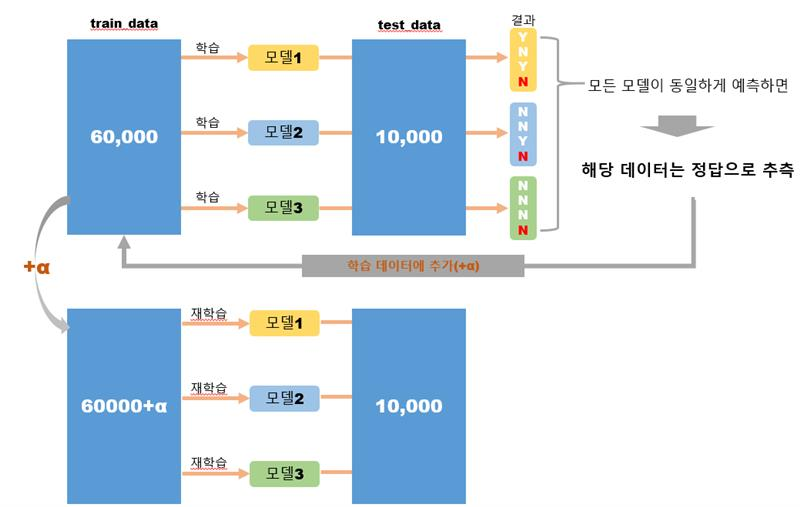

In [338]:
Image('image/test2train.jpg')

### 6.2.2. 모델별 예측 진행

In [821]:
from catboost import CatBoostClassifier

model = CatBoostClassifier()

start=time.time()

model.fit(X_train,Y_train)

pred_CAT=model.predict(X_test)

(time.time()-start)/60

Learning rate set to 0.059041
0:	learn: 0.6747921	total: 608ms	remaining: 10m 6s
1:	learn: 0.6579554	total: 1.09s	remaining: 9m 5s
2:	learn: 0.6430374	total: 1.59s	remaining: 8m 48s
3:	learn: 0.6311885	total: 2.1s	remaining: 8m 43s
4:	learn: 0.6202803	total: 2.6s	remaining: 8m 38s
5:	learn: 0.6105343	total: 2.91s	remaining: 8m 1s
6:	learn: 0.6017669	total: 3.41s	remaining: 8m 3s
7:	learn: 0.5940956	total: 3.9s	remaining: 8m 3s
8:	learn: 0.5873024	total: 4.22s	remaining: 7m 44s
9:	learn: 0.5805817	total: 4.6s	remaining: 7m 35s
10:	learn: 0.5752422	total: 5.18s	remaining: 7m 46s
11:	learn: 0.5707385	total: 5.7s	remaining: 7m 49s
12:	learn: 0.5663676	total: 6.1s	remaining: 7m 43s
13:	learn: 0.5626365	total: 6.66s	remaining: 7m 49s
14:	learn: 0.5593243	total: 7.19s	remaining: 7m 52s
15:	learn: 0.5562758	total: 7.7s	remaining: 7m 53s
16:	learn: 0.5529009	total: 8.1s	remaining: 7m 48s
17:	learn: 0.5502300	total: 8.6s	remaining: 7m 49s
18:	learn: 0.5478266	total: 9.09s	remaining: 7m 49s
19:	l

7.802363606293996

In [822]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_jobs=-1)

model.fit(X_train,Y_train)

pred_RF = model.predict(X_test)

In [823]:
from xgboost import XGBClassifier

model = XGBClassifier(
        colsample_bytree= 0.5532036630135703, 
        gamma=1.0, 
        learning_rate= 0.1555825731884874, 
        max_delta_step= 0.09038638082244055, 
        max_depth= 9, 
        min_child_weight= 6.462834212552353, 
        n_estimators= 269, 
        subsample= 0.8740670584510566, n_jobs=-1)

model.fit(X_train,Y_train)

pred_XGB = model.predict(X_test)

In [824]:
from lightgbm import LGBMClassifier

model = LGBMClassifier()

model.fit(X_train,Y_train)

pred_LGBM = model.predict(X_test)

### 6.2.3. 테스트 데이터 활용

테스트 데이터에 여러 모델이 동일한 결과를 내는 것은 정답으로 간주하고 학습데이터에 추가함

In [825]:
#예측결과를 모아놓을 데이터프레임 최초 생성 
pred_all=pd.DataFrame(pred_RF,columns=['pred_0'])

In [826]:
pred_all

,pred_0
0,1
1,1
2,1
3,1
4,0
...,...
9995,1
9996,0
9997,0
9998,1


In [827]:
# #Aidu에서는 계속 데이터가 삭제되니 저장해놓고, 불러다 씀
# pred_all= pd.read_csv(sacp_framework.config.data_dir + '/pred_all.csv')
# pred_all

In [828]:
#pred_all의 마지막 컬럼 자리에 예측결과를 추가하는 함수
def pred_add(pred):
    column_name=str('pred_'+str(len(pred_all.columns))) 
    pred_all.insert(len(pred_all.columns),column_name,pred,True)

In [831]:
pred_add(pred_CAT)

pred_add(pred_XGB)

pred_add(pred_LGBM)

In [833]:
#pred_all 저장 (쓸때만 주석 풀고 사용)
pred_all.to_csv(sacp_framework.config.data_dir + '/pred_all.csv',header=True, index=False, encoding='utf-8')

같은 예측값을 가지는 것을 추출하여 학습데이터에 추가

In [834]:
#각 행에 대해서 열 전체의 합이 컬럼수와 동일하거나 0이면 모두 같은 값이미 
same=[]
for i in pred_all.index:
    if pred_all.iloc[i,:].sum() == len(pred_all.columns):
        same.append("Y")
    elif pred_all.iloc[i,:].sum() == 0:
        same.append("Y")
    else:
        same.append("N")

In [835]:
pred_all['same']=same

In [838]:
#테스트 데이터중 각 모델이 모두 동일한 결과를 낸 것은 아래와 같음 - 8620건
pred_all[pred_all['same']=='Y'].index

Int64Index([   0,    1,    2,    3,    4,    5,    7,    8,    9,   11,
            ...
            9988, 9990, 9992, 9993, 9994, 9995, 9996, 9997, 9998, 9999],
           dtype='int64', length=8620)

In [839]:
#test_data에 pred_same의 값을 추가해서 train_data에 넣어주기 위해 pred_same에 pred_0의 값을 저장함 cf. same의 값을 저장하는 것이 아님
pred_same=pred_all.loc[pred_all[pred_all['same']=='Y'].index,['pred_0']]

In [841]:
#현재 train_data와 test_data는 전처리 되어있으므로 새로 불러옴
train_data= pd.read_csv(sacp_framework.config.data_dir + '/ep1_train_t1_t2_DB.csv')

test_data = pd.read_csv(sacp_framework.config.data_dir + '/ep1_test_t1_t2.csv')

In [843]:
#학습데이터에 추가할 데이터을 p_same의 index로 찾아 train_add로 생성
train_add=test_data.iloc[pred_same.index,:]
train_add

,id,new_date,mob_trmn_cnt,int_trmn_cnt,mob_cont_cnt,int_cont_cnt,cust_ctg_type_itg_cd,sex_type_itg_cd,vip_adm_tag_itg_cd,olcb_sbsc_yn,inet_sbsc_yn,soip_sbsc_yn,iptv_sbsc_yn,pstn_sbsc_yn,wibro_sbsc_yn,mphon_sbsc_yn,comb_prod_sbsc_yn,efct_mphon_sbsc_cascnt,efct_pstn_sbsc_cascnt,efct_soip_sbsc_cascnt,efct_inet_sbsc_cascnt,efct_iptv_sbsc_cascnt,efct_wibro_sbsc_cascnt,dt_stop_yn,inet_light_sbsc_yn,mphon_comb_yn,inet_comb_yn,iptv_comb_yn,mphon_aftmn_eperd_itg_cd,inet_aftmn_eperd_itg_cd,inet_trmn_why_itg_cd,mphon_trmn_why_itg_cd,npay_yn,rmonth_pstn_bill_amt,r3m_avg_bill_amt,r6m_inet_pssn_comb_yn,r3m_mphon_avg_arpu_amt,r3m_inet_avg_arpu_amt,r6m_mphon_avg_arpu_amt,r6m_inet_avg_arpu_amt,tngr_sbscr_exist_hshld_yn,smph_use_yn,kids_wless_adtn_svc_sbsc_yn,kids_wrlin_adtn_svc_sbsc_yn,iptv_infn_conts_use_yn,inet_engt_exp_rperd_itg_cd,mphon_engt_exp_rperd_itg_cd,iptv_engt_exp_rperd_itg_cd,kibot_sbsc_yn,pad_use_yn,r3m_ppv_avg_use_amt,r6m_iptv_first_ppv_use_yn,voc1_daycnt,voc2_daycnt,voc3_daycnt,voc4_daycnt,voc5_daycnt,voc6_daycnt,voc7_daycnt,voc8_daycnt,voc9_daycnt,voc10_daycnt,voc11_daycnt,voc12_daycnt,trmn_voc_yn,voc_sum_cnt,day_sum_cnt
0,E1000001,20151123,0,0,3,1,10001,F,_,Y,N,N,N,N,N,Y,Y,1.0,0.0,0.0,0.0,0.0,0.0,N,N,Y,Y,Y,_,_,_,_,N,0.0,57585.000,N,33549.000,0.000,33147.500,0.000,N,Y,N,N,N,_,R12,_,N,N,0.0,N,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,1
1,E1000002,20141120,0,0,1,1,10001,M,_,Y,Y,N,Y,N,N,Y,Y,1.0,0.0,0.0,1.0,1.0,0.0,N,N,Y,Y,Y,_,_,_,_,N,0.0,484793.000,Y,138772.683,24200.000,87158.525,24200.000,N,Y,N,N,N,R16,R10,R16,N,N,0.0,N,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,1
2,E1000003,20130701,0,0,4,1,10001,M,BM,Y,N,N,N,N,N,Y,Y,1.0,0.0,0.0,0.0,0.0,0.0,N,N,Y,Y,N,_,_,_,_,Y,0.0,60378.000,N,44874.653,0.000,38871.937,0.000,Y,Y,N,N,N,_,R22,_,N,N,0.0,N,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,1
3,E1000004,20200221,0,0,1,0,10001,M,_,Y,N,N,N,N,N,Y,N,1.0,0.0,0.0,0.0,0.0,0.0,N,N,N,N,N,_,_,_,_,N,0.0,85558.000,N,64840.333,0.000,64524.682,0.000,N,Y,N,N,N,_,R24,_,N,N,0.0,N,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,1
4,E1000005,20170828,0,0,3,2,10001,M,_,N,Y,N,Y,N,N,Y,Y,1.0,0.0,0.0,2.0,3.0,0.0,N,N,N,Y,Y,_,_,_,_,N,0.0,179369.333,Y,47042.000,65266.667,47042.000,60200.000,N,Y,N,Y,N,000,R14,000,N,N,0.0,N,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,E1009996,20200525,0,0,0,1,10001,F,_,Y,N,N,N,N,N,Y,N,1.0,0.0,0.0,0.0,0.0,0.0,N,N,N,N,N,_,R37,10453,_,N,0.0,57212.000,N,39896.712,0.000,61393.591,0.000,N,Y,N,N,N,_,R21,_,N,N,0.0,N,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,1
9996,E1009997,20180122,0,0,0,1,10001,M,_,N,Y,N,Y,N,N,N,Y,0.0,0.0,0.0,2.0,2.0,0.0,Y,N,N,Y,Y,_,_,_,_,N,0.0,44660.333,Y,0.000,21830.333,0.000,40725.167,N,N,N,N,N,R05,_,R05,N,N,0.0,N,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,1,1
9997,E1009998,20161026,0,0,1,0,10001,F,_,Y,N,N,N,N,N,Y,N,1.0,0.0,0.0,0.0,0.0,0.0,N,N,N,N,N,_,_,_,_,N,0.0,39893.667,N,24140.000,0.000,23316.500,0.000,N,Y,N,N,N,_,R06,_,N,N,0.0,N,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0,2,2
9998,E1009999,20130923,0,0,3,1,10001,M,BM,Y,N,N,N,N,N,Y,Y,1.0,0.0,0.0,0.0,0.0,0.0,N,N,Y,Y,Y,_,_,_,_,N,0.0,47466.667,N,45341.833,0.000,43161.492,0.000,N,Y,N,N,N,_,R12,_,N,N,0.0,N,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,1


In [845]:
#pred_same을 status로 추가함. 
train_add['status']=pred_same

In [846]:
#1/0인 status를 다시 Y/N으로 변경
train_add.loc[train_add['status']==1,'status']='Y'
train_add.loc[train_add['status']==0,'status']='N'

In [847]:
train_add

,id,new_date,mob_trmn_cnt,int_trmn_cnt,mob_cont_cnt,int_cont_cnt,cust_ctg_type_itg_cd,sex_type_itg_cd,vip_adm_tag_itg_cd,olcb_sbsc_yn,inet_sbsc_yn,soip_sbsc_yn,iptv_sbsc_yn,pstn_sbsc_yn,wibro_sbsc_yn,mphon_sbsc_yn,comb_prod_sbsc_yn,efct_mphon_sbsc_cascnt,efct_pstn_sbsc_cascnt,efct_soip_sbsc_cascnt,efct_inet_sbsc_cascnt,efct_iptv_sbsc_cascnt,efct_wibro_sbsc_cascnt,dt_stop_yn,inet_light_sbsc_yn,mphon_comb_yn,inet_comb_yn,iptv_comb_yn,mphon_aftmn_eperd_itg_cd,inet_aftmn_eperd_itg_cd,inet_trmn_why_itg_cd,mphon_trmn_why_itg_cd,npay_yn,rmonth_pstn_bill_amt,r3m_avg_bill_amt,r6m_inet_pssn_comb_yn,r3m_mphon_avg_arpu_amt,r3m_inet_avg_arpu_amt,r6m_mphon_avg_arpu_amt,r6m_inet_avg_arpu_amt,tngr_sbscr_exist_hshld_yn,smph_use_yn,kids_wless_adtn_svc_sbsc_yn,kids_wrlin_adtn_svc_sbsc_yn,iptv_infn_conts_use_yn,inet_engt_exp_rperd_itg_cd,mphon_engt_exp_rperd_itg_cd,iptv_engt_exp_rperd_itg_cd,kibot_sbsc_yn,pad_use_yn,r3m_ppv_avg_use_amt,r6m_iptv_first_ppv_use_yn,voc1_daycnt,voc2_daycnt,voc3_daycnt,voc4_daycnt,voc5_daycnt,voc6_daycnt,voc7_daycnt,voc8_daycnt,voc9_daycnt,voc10_daycnt,voc11_daycnt,voc12_daycnt,trmn_voc_yn,voc_sum_cnt,day_sum_cnt,status
0,E1000001,20151123,0,0,3,1,10001,F,_,Y,N,N,N,N,N,Y,Y,1.0,0.0,0.0,0.0,0.0,0.0,N,N,Y,Y,Y,_,_,_,_,N,0.0,57585.000,N,33549.000,0.000,33147.500,0.000,N,Y,N,N,N,_,R12,_,N,N,0.0,N,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,1,Y
1,E1000002,20141120,0,0,1,1,10001,M,_,Y,Y,N,Y,N,N,Y,Y,1.0,0.0,0.0,1.0,1.0,0.0,N,N,Y,Y,Y,_,_,_,_,N,0.0,484793.000,Y,138772.683,24200.000,87158.525,24200.000,N,Y,N,N,N,R16,R10,R16,N,N,0.0,N,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,1,Y
2,E1000003,20130701,0,0,4,1,10001,M,BM,Y,N,N,N,N,N,Y,Y,1.0,0.0,0.0,0.0,0.0,0.0,N,N,Y,Y,N,_,_,_,_,Y,0.0,60378.000,N,44874.653,0.000,38871.937,0.000,Y,Y,N,N,N,_,R22,_,N,N,0.0,N,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,1,Y
3,E1000004,20200221,0,0,1,0,10001,M,_,Y,N,N,N,N,N,Y,N,1.0,0.0,0.0,0.0,0.0,0.0,N,N,N,N,N,_,_,_,_,N,0.0,85558.000,N,64840.333,0.000,64524.682,0.000,N,Y,N,N,N,_,R24,_,N,N,0.0,N,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,1,Y
4,E1000005,20170828,0,0,3,2,10001,M,_,N,Y,N,Y,N,N,Y,Y,1.0,0.0,0.0,2.0,3.0,0.0,N,N,N,Y,Y,_,_,_,_,N,0.0,179369.333,Y,47042.000,65266.667,47042.000,60200.000,N,Y,N,Y,N,000,R14,000,N,N,0.0,N,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,1,1,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,E1009996,20200525,0,0,0,1,10001,F,_,Y,N,N,N,N,N,Y,N,1.0,0.0,0.0,0.0,0.0,0.0,N,N,N,N,N,_,R37,10453,_,N,0.0,57212.000,N,39896.712,0.000,61393.591,0.000,N,Y,N,N,N,_,R21,_,N,N,0.0,N,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,1,Y
9996,E1009997,20180122,0,0,0,1,10001,M,_,N,Y,N,Y,N,N,N,Y,0.0,0.0,0.0,2.0,2.0,0.0,Y,N,N,Y,Y,_,_,_,_,N,0.0,44660.333,Y,0.000,21830.333,0.000,40725.167,N,N,N,N,N,R05,_,R05,N,N,0.0,N,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,1,1,N
9997,E1009998,20161026,0,0,1,0,10001,F,_,Y,N,N,N,N,N,Y,N,1.0,0.0,0.0,0.0,0.0,0.0,N,N,N,N,N,_,_,_,_,N,0.0,39893.667,N,24140.000,0.000,23316.500,0.000,N,Y,N,N,N,_,R06,_,N,N,0.0,N,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0,2,2,N
9998,E1009999,20130923,0,0,3,1,10001,M,BM,Y,N,N,N,N,N,Y,Y,1.0,0.0,0.0,0.0,0.0,0.0,N,N,Y,Y,Y,_,_,_,_,N,0.0,47466.667,N,45341.833,0.000,43161.492,0.000,N,Y,N,N,N,_,R12,_,N,N,0.0,N,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,1,Y


In [849]:
train_add.to_csv(sacp_framework.config.data_dir + '/train_add.csv',header=True, index=False, encoding='utf-8')

In [853]:
train_add=pd.read_csv(sacp_framework.config.data_dir + '/train_add.csv')

In [854]:
train_add.groupby(['status']).count()

,id,new_date,mob_trmn_cnt,int_trmn_cnt,mob_cont_cnt,int_cont_cnt,cust_ctg_type_itg_cd,sex_type_itg_cd,vip_adm_tag_itg_cd,olcb_sbsc_yn,inet_sbsc_yn,soip_sbsc_yn,iptv_sbsc_yn,pstn_sbsc_yn,wibro_sbsc_yn,mphon_sbsc_yn,comb_prod_sbsc_yn,efct_mphon_sbsc_cascnt,efct_pstn_sbsc_cascnt,efct_soip_sbsc_cascnt,efct_inet_sbsc_cascnt,efct_iptv_sbsc_cascnt,efct_wibro_sbsc_cascnt,dt_stop_yn,inet_light_sbsc_yn,mphon_comb_yn,inet_comb_yn,iptv_comb_yn,mphon_aftmn_eperd_itg_cd,inet_aftmn_eperd_itg_cd,inet_trmn_why_itg_cd,mphon_trmn_why_itg_cd,npay_yn,rmonth_pstn_bill_amt,r3m_avg_bill_amt,r6m_inet_pssn_comb_yn,r3m_mphon_avg_arpu_amt,r3m_inet_avg_arpu_amt,r6m_mphon_avg_arpu_amt,r6m_inet_avg_arpu_amt,tngr_sbscr_exist_hshld_yn,smph_use_yn,kids_wless_adtn_svc_sbsc_yn,kids_wrlin_adtn_svc_sbsc_yn,iptv_infn_conts_use_yn,inet_engt_exp_rperd_itg_cd,mphon_engt_exp_rperd_itg_cd,iptv_engt_exp_rperd_itg_cd,kibot_sbsc_yn,pad_use_yn,r3m_ppv_avg_use_amt,r6m_iptv_first_ppv_use_yn,voc1_daycnt,voc2_daycnt,voc3_daycnt,voc4_daycnt,voc5_daycnt,voc6_daycnt,voc7_daycnt,voc8_daycnt,voc9_daycnt,voc10_daycnt,voc11_daycnt,voc12_daycnt,trmn_voc_yn,voc_sum_cnt,day_sum_cnt
status,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
N,3203,3203,3203,3203,3203,3203,3203,3203,3203,3203,3203,3203,3203,3203,3203,3203,3203,3203,3203,3203,3203,3203,3203,3203,3203,3203,3203,3203,3203,3203,3203,3203,3203,3203,3203,3203,3203,3203,3203,3203,3203,3203,3203,3203,3203,3203,3203,3203,3203,3203,3203,3203,3203,3203,3203,3203,3203,3203,3203,3203,3203,3203,3203,3203,3203,3203,3203
Y,5417,5417,5417,5417,5417,5417,5417,5417,5417,5417,5417,5417,5417,5417,5417,5417,5417,5417,5417,5417,5417,5417,5417,5417,5417,5417,5417,5417,5417,5417,5417,5417,5417,5417,5417,5417,5417,5417,5417,5417,5417,5417,5417,5417,5417,5417,5417,5417,5417,5417,5417,5417,5417,5417,5417,5417,5417,5417,5417,5417,5417,5417,5417,5417,5417,5417,5417


In [856]:
train_add[train_add['status']=='N']

,id,new_date,mob_trmn_cnt,int_trmn_cnt,mob_cont_cnt,int_cont_cnt,cust_ctg_type_itg_cd,sex_type_itg_cd,vip_adm_tag_itg_cd,olcb_sbsc_yn,inet_sbsc_yn,soip_sbsc_yn,iptv_sbsc_yn,pstn_sbsc_yn,wibro_sbsc_yn,mphon_sbsc_yn,comb_prod_sbsc_yn,efct_mphon_sbsc_cascnt,efct_pstn_sbsc_cascnt,efct_soip_sbsc_cascnt,efct_inet_sbsc_cascnt,efct_iptv_sbsc_cascnt,efct_wibro_sbsc_cascnt,dt_stop_yn,inet_light_sbsc_yn,mphon_comb_yn,inet_comb_yn,iptv_comb_yn,mphon_aftmn_eperd_itg_cd,inet_aftmn_eperd_itg_cd,inet_trmn_why_itg_cd,mphon_trmn_why_itg_cd,npay_yn,rmonth_pstn_bill_amt,r3m_avg_bill_amt,r6m_inet_pssn_comb_yn,r3m_mphon_avg_arpu_amt,r3m_inet_avg_arpu_amt,r6m_mphon_avg_arpu_amt,r6m_inet_avg_arpu_amt,tngr_sbscr_exist_hshld_yn,smph_use_yn,kids_wless_adtn_svc_sbsc_yn,kids_wrlin_adtn_svc_sbsc_yn,iptv_infn_conts_use_yn,inet_engt_exp_rperd_itg_cd,mphon_engt_exp_rperd_itg_cd,iptv_engt_exp_rperd_itg_cd,kibot_sbsc_yn,pad_use_yn,r3m_ppv_avg_use_amt,r6m_iptv_first_ppv_use_yn,voc1_daycnt,voc2_daycnt,voc3_daycnt,voc4_daycnt,voc5_daycnt,voc6_daycnt,voc7_daycnt,voc8_daycnt,voc9_daycnt,voc10_daycnt,voc11_daycnt,voc12_daycnt,trmn_voc_yn,voc_sum_cnt,day_sum_cnt,status
4,E1000005,20170828,0,0,3,2,10001,M,_,N,Y,N,Y,N,N,Y,Y,1.0,0.0,0.0,2.0,3.0,0.0,N,N,N,Y,Y,_,_,_,_,N,0.0,179369.333,Y,47042.000,65266.667,47042.000,60200.000,N,Y,N,Y,N,000,R14,000,N,N,0.0,N,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,1,1,N
7,E1000009,20200505,0,0,1,0,10001,M,_,N,Y,N,Y,N,N,Y,Y,4.0,0.0,0.0,1.0,1.0,0.0,N,N,Y,Y,Y,_,_,_,_,Y,0.0,1248598.000,Y,221599.719,0.000,223124.576,0.000,N,Y,N,N,N,_,R13,P37,N,N,0.0,N,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,1,N
9,E1000012,20180908,0,0,2,1,10001,F,_,Y,N,N,N,N,N,Y,Y,1.0,0.0,0.0,0.0,0.0,0.0,N,N,Y,Y,Y,_,_,_,_,Y,0.0,73808.667,N,32868.683,0.000,30625.975,0.000,N,Y,N,N,N,_,R07,_,N,N,0.0,N,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,1,N
19,E1000023,20200117,0,0,2,0,10001,M,_,N,N,N,N,N,N,Y,N,2.0,0.0,0.0,0.0,0.0,0.0,N,N,N,N,N,_,_,_,_,Y,0.0,135136.667,N,6991.667,0.000,75754.500,0.000,N,Y,N,N,N,_,R23,_,N,N,0.0,N,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,1,N
24,E1000029,20180928,0,0,1,0,10001,F,_,N,N,N,N,N,N,Y,N,1.0,0.0,0.0,0.0,0.0,0.0,N,N,N,N,N,_,_,_,_,N,0.0,20815.333,N,20815.333,0.000,17038.000,0.000,N,N,N,N,N,_,R07,_,N,N,0.0,N,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2,2,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8610,E1009989,20150410,0,0,1,0,10001,M,_,Y,Y,N,Y,Y,N,Y,Y,2.0,2.0,0.0,1.0,2.0,0.0,N,N,Y,Y,Y,_,_,_,_,N,11160.0,138864.333,Y,67906.000,7096.000,58998.500,7096.000,N,Y,N,N,N,R35,R06,R01,N,N,0.0,N,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,1,1,N
8613,E1009994,20091026,0,0,0,1,10001,M,_,Y,Y,N,Y,N,N,N,Y,0.0,0.0,0.0,1.0,1.0,0.0,N,N,N,Y,Y,R15,_,_,10183,N,0.0,28251.333,Y,0.000,19980.333,0.000,18155.333,N,N,N,N,N,P37,_,R03,N,N,0.0,N,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,1,1,N
8614,E1009995,20170703,0,0,1,0,10001,F,_,Y,N,N,N,N,N,Y,N,1.0,0.0,0.0,0.0,0.0,0.0,N,N,N,N,N,_,_,_,_,N,0.0,65744.667,N,64221.667,0.000,63730.000,0.000,N,Y,N,N,N,_,000,_,N,N,0.0,N,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,1,N
8616,E1009997,20180122,0,0,0,1,10001,M,_,N,Y,N,Y,N,N,N,Y,0.0,0.0,0.0,2.0,2.0,0.0,Y,N,N,Y,Y,_,_,_,_,N,0.0,44660.333,Y,0.000,21830.333,0.000,40725.167,N,N,N,N,N,R05,_,R05,N,N,0.0,N,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,1,1,N


In [857]:
#train_data에 해지인 건을 합쳐주고 index를 새로 생성
train_data=pd.concat([train_data,train_add[train_add['status']=='N']], ignore_index=True)

In [859]:
#학습데이터가 62863 개로 증가함
train_data

,id,status,new_date,mob_trmn_cnt,int_trmn_cnt,mob_cont_cnt,int_cont_cnt,cust_ctg_type_itg_cd,sex_type_itg_cd,vip_adm_tag_itg_cd,olcb_sbsc_yn,inet_sbsc_yn,soip_sbsc_yn,iptv_sbsc_yn,pstn_sbsc_yn,wibro_sbsc_yn,mphon_sbsc_yn,comb_prod_sbsc_yn,efct_mphon_sbsc_cascnt,efct_pstn_sbsc_cascnt,efct_soip_sbsc_cascnt,efct_inet_sbsc_cascnt,efct_iptv_sbsc_cascnt,efct_wibro_sbsc_cascnt,dt_stop_yn,inet_light_sbsc_yn,mphon_comb_yn,inet_comb_yn,iptv_comb_yn,mphon_aftmn_eperd_itg_cd,inet_aftmn_eperd_itg_cd,inet_trmn_why_itg_cd,mphon_trmn_why_itg_cd,npay_yn,rmonth_pstn_bill_amt,r3m_avg_bill_amt,r6m_inet_pssn_comb_yn,r3m_mphon_avg_arpu_amt,r3m_inet_avg_arpu_amt,r6m_mphon_avg_arpu_amt,r6m_inet_avg_arpu_amt,tngr_sbscr_exist_hshld_yn,smph_use_yn,kids_wless_adtn_svc_sbsc_yn,kids_wrlin_adtn_svc_sbsc_yn,iptv_infn_conts_use_yn,inet_engt_exp_rperd_itg_cd,mphon_engt_exp_rperd_itg_cd,iptv_engt_exp_rperd_itg_cd,kibot_sbsc_yn,pad_use_yn,r3m_ppv_avg_use_amt,r6m_iptv_first_ppv_use_yn,voc1_daycnt,voc2_daycnt,voc3_daycnt,voc4_daycnt,voc5_daycnt,voc6_daycnt,voc7_daycnt,voc8_daycnt,voc9_daycnt,voc10_daycnt,voc11_daycnt,voc12_daycnt,trmn_voc_yn,voc_sum_cnt,day_sum_cnt
0,E1000001,Y,20170421,0,0,1,0,10001,F,_,Y,Y,N,Y,N,N,Y,Y,1.0,0.0,0.0,1.0,2.0,0.0,N,N,Y,Y,Y,_,_,_,_,Y,0.0,127237.000,Y,40393.333,21780.000,41749.517,21774.500,N,Y,N,N,N,R09,R12,R09,N,N,0.0,N,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,1
1,E1000002,N,20131203,0,0,2,0,10001,M,BM,N,N,N,N,N,N,Y,N,1.0,0.0,0.0,0.0,0.0,0.0,N,N,N,N,N,_,_,_,_,N,0.0,36700.000,N,34460.500,0.000,35569.213,0.000,N,Y,N,N,N,_,R06,_,N,N,0.0,N,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,1,1
2,E1000003,N,20170731,0,0,1,1,10001,M,_,N,Y,N,Y,Y,N,N,Y,0.0,1.0,0.0,1.0,2.0,0.0,N,N,Y,Y,Y,_,_,_,_,N,1100.0,30000.000,Y,0.000,14300.000,0.000,14300.000,N,N,N,N,N,000,_,000,N,N,0.0,N,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,1,1
3,E1000004,Y,20090930,0,0,4,1,10001,F,BM,Y,Y,N,Y,N,N,Y,Y,1.0,0.0,0.0,1.0,1.0,0.0,N,N,Y,Y,Y,_,_,_,_,Y,0.0,72767.667,Y,34747.417,27500.000,34714.917,27500.000,N,Y,N,N,N,P36,R11,P36,N,N,0.0,N,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0,2,2
4,E1000005,N,20151121,0,0,1,1,10001,F,BM,Y,Y,N,Y,Y,N,Y,Y,2.0,1.0,0.0,2.0,2.0,0.0,Y,N,Y,Y,Y,_,_,_,_,N,950.0,103365.333,Y,59856.279,27041.500,58386.112,25621.700,N,Y,N,N,N,R27,R22,R27,N,N,0.0,N,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62858,E1009989,N,20150410,0,0,1,0,10001,M,_,Y,Y,N,Y,Y,N,Y,Y,2.0,2.0,0.0,1.0,2.0,0.0,N,N,Y,Y,Y,_,_,_,_,N,11160.0,138864.333,Y,67906.000,7096.000,58998.500,7096.000,N,Y,N,N,N,R35,R06,R01,N,N,0.0,N,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,1,1
62859,E1009994,N,20091026,0,0,0,1,10001,M,_,Y,Y,N,Y,N,N,N,Y,0.0,0.0,0.0,1.0,1.0,0.0,N,N,N,Y,Y,R15,_,_,10183,N,0.0,28251.333,Y,0.000,19980.333,0.000,18155.333,N,N,N,N,N,P37,_,R03,N,N,0.0,N,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,1,1
62860,E1009995,N,20170703,0,0,1,0,10001,F,_,Y,N,N,N,N,N,Y,N,1.0,0.0,0.0,0.0,0.0,0.0,N,N,N,N,N,_,_,_,_,N,0.0,65744.667,N,64221.667,0.000,63730.000,0.000,N,Y,N,N,N,_,000,_,N,N,0.0,N,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,1
62861,E1009997,N,20180122,0,0,0,1,10001,M,_,N,Y,N,Y,N,N,N,Y,0.0,0.0,0.0,2.0,2.0,0.0,Y,N,N,Y,Y,_,_,_,_,N,0.0,44660.333,Y,0.000,21830.333,0.000,40725.167,N,N,N,N,N,R05,_,R05,N,N,0.0,N,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,1,1


학습데이터 추가 후 저장해주고, 활용할 때는 해당 데이터를 로드하여 전처리부터 수행함

In [860]:
#test- 해지를 활용할 때 데이터 저장
train_data.to_csv(sacp_framework.config.data_dir + '/ep1_train_t1_t2_DBTrmn.csv',header=True, index=False, encoding='utf-8')

In [861]:
#train_data에 유지인 건을 합쳐주고 index를 새로 생성
train_data=pd.concat([train_data,train_add[train_add['status']=='Y']], ignore_index=True)

In [862]:
#test- 해지/유지를 모두 를 활용할 때 데이터 저장
train_data.to_csv(sacp_framework.config.data_dir + '/ep1_train_t1_t2_DBTall.csv',header=True, index=False, encoding='utf-8')

# **7. 최종 예측**

## 7.1. 단일 모델 중 가장 성능이 좋은 XGBoost로 결과 파일 저장

In [952]:
from xgboost import XGBClassifier

model = XGBClassifier(
        colsample_bytree= 0.5532036630135703, 
        gamma=1.0, 
        learning_rate= 0.1555825731884874, 
        max_delta_step= 0.09038638082244055, 
        max_depth= 9, 
        min_child_weight= 6.462834212552353, 
        n_estimators= 269, 
        subsample= 0.8740670584510566, n_jobs=-1)

model.fit(X_train,Y_train)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5532036630135703,
              gamma=1.0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.1555825731884874,
              max_delta_step=0.09038638082244055, max_depth=9,
              min_child_weight=6.462834212552353, missing=nan,
              monotone_constraints='()', n_estimators=269, n_jobs=-1,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=0.8740670584510566,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [953]:
X_train.shape, Y_train.shape,X_test.shape

((62863, 44), (62863,), (10000, 44))

In [954]:
pred_XGB = model.predict(X_test)

In [955]:
#제출을 위해 결과 저장
aiplay1088_result_ep1 = pd.concat([test_data_id,pd.Series(pred_XGB)],axis=1)

#1/0인 status를 다시 Y/N으로 변경
aiplay1088_result_ep1.loc[aiplay1088_result_ep1[0]==1,0]='Y'
aiplay1088_result_ep1.loc[aiplay1088_result_ep1[0]==0,0]='N'



aiplay1088_result_ep1.to_csv(sacp_framework.config.data_dir + '/aiplay1088_result_ep1.csv',header=False, index=False, encoding='utf-8')

## 7.2. Voting 알고리즘 적용

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV, RidgeClassifier
from catboost import CatBoostClassifier 
from sklearn.model_selection import cross_validate
# VotingClassifier
from sklearn.ensemble import VotingClassifier

# ensemble 할 model 정의
models = [

    ('rfc', RandomForestClassifier()),

    ('xgb', XGBClassifier(colsample_bytree= 0.5532036630135703,
                          gamma=1.0, 
                          learning_rate= 0.1555825731884874, 
                          max_delta_step= 0.09038638082244055, 
                          max_depth= 9, 
                          min_child_weight= 6.462834212552353, 
                          n_estimators= 269, 
                          subsample= 0.8740670584510566,
                          n_jobs=-1)),

    ('cat', CatBoostClassifier()),
]

# soft vote
soft_vote  = VotingClassifier(models, voting='soft')
soft_vote_cv = cross_validate(soft_vote, x_train, y_train, cv=5)
soft_vote.fit(x_train, y_train)
y_pred = soft_vote.predict(x_test)

# 라이브러리 import
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# print
print("Soft_Vote Test Accuracy: ", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=['해지','유지']))
print(confusion_matrix(y_true=y_test, y_pred=y_pred))

# 최종 예측
soft_vote.fit(X_train, Y_train)
y_pred = soft_vote.predict(X_test)

#제출을 위해 결과 저장
aiplay1088_result_ep1 = pd.concat([test_data_id,pd.Series(y_pred)],axis=1)

#1/0인 status를 다시 Y/N으로 변경
aiplay1088_result_ep1.loc[aiplay1088_result_ep1[0]==1,0]='Y'
aiplay1088_result_ep1.loc[aiplay1088_result_ep1[0]==0,0]='N'

aiplay1088_result_ep1.to_csv(sacp_framework.config.data_dir + '/aiplay1088_result_ep1.csv',header=False, index=False, encoding='utf-8')